In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import math
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster import hierarchy

In [3]:
class TextValueDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, dial_col):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dial_col = dial_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        text = row[self.dial_col]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [4]:
def create_dataloader(df, tokenizer, dial_col, max_length=256, batch_size=16):
    dataset = TextValueDataset(df, tokenizer, max_length, dial_col)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [10]:
def appraise_dataset(df, modeldir, tokenizer, device, dial_col='utterances'):
    dataloader = create_dataloader(df, tokenizer, dial_col)
    
    for model_name in os.listdir(modeldir):
        # model_name='./models/google-t5/suddenness_google-t5/'
        if '.ipy' in model_name or 'effort' not in model_name:
            continue
        column = str.join('_', model_name.split('_')[:-1])
        print(column)
        model = AutoModelForSequenceClassification.from_pretrained(os.path.join('./models/google-t5/', model_name))
        model = model.to(device)
        app_store = []
        for batch in tqdm(dataloader):
            with torch.no_grad():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask
                        ).logits
            logits = list(itertools.chain.from_iterable(outputs.cpu().numpy().tolist()))
            logits = [(l*4)+1 for l in logits]
            app_store.extend(logits)
        df[column] = app_store
        
        app_store = []
        # Cleanup
        model.to('cpu')
        del model
        torch.cuda.empty_cache()

    return df

In [6]:
def correlation_matrix(df, strs):
    col_list = []
    # col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
    for col in df.columns:
        for s in strs:
            if s in col:
                col_list.append(col)
    
    df = df[col_list]
    corr_matrix = df.corr()
    print(corr_matrix)
    return corr_matrix

def plot_matrix(corr_matrix):
    plt.figure(figsize=(32, 24))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [7]:
def split_merge(df, sp_col):
    cols = list(df.columns)
    cols = cols[:3] + [col + '_' + sp_col for col in cols[3:]]
    col_map = {list(df.columns)[i]:cols[i] for i in range(len(cols))}
    df = df.rename(columns=col_map)
    return df

def remake_df(df, appdf, sp1col, sp2col):
    sp1_df = appdf[appdf['indices'] == 1]
    sp2_df = appdf[appdf['indices'] == 0]
    sp1_df.rename(columns={"utterances": sp1col}, inplace=True)
    sp2_df.rename(columns={"utterances": sp2col}, inplace=True)
    sp1_df.reset_index(inplace=True)
    sp2_df.reset_index(inplace=True)
    sp1_df = split_merge(sp1_df, sp1col)
    sp2_df = split_merge(sp2_df, sp2col)
    df = pd.concat([df, sp1_df], axis=1)
    df = pd.concat([df, sp2_df], axis=1)
    return df

In [8]:
def main(datapath, sp1col, sp2col, savepath, modeldir):
    if 'csv' in datapath:
        df = pd.read_csv(datapath, low_memory=False)
    else:
        df = pd.read_json(datapath)
    df = df.dropna()
    tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    sp1_list = list(df[sp1col])
    sp2_list = list(df[sp2col])
    indexes = [(i + 1) % 2 for i in range(len(df[sp1col]) * 2)]
    utterance_list = []
    for i in range(len(sp1_list)):
        utterance_list.append(sp1_list[i])
        utterance_list.append(sp2_list[i])
    appdf = {
             'indices':indexes, 
             'utterances':utterance_list
            }
    appdf = pd.DataFrame(appdf)
    appdf = appraise_dataset(appdf, modeldir, tokenizer, device)
    df = remake_df(df, appdf, sp1col, sp2col)
    df.to_csv(savepath)

In [25]:
if __name__ == '__main__':
    datapath = './dialogues/wassa_conv_updated.csv'
    sp1 = 'sp1'
    sp2 = 'sp2'
    modeldir = './models/google-t5/'
    data_savepath = './appraised_dialogues/google-t5_wassa_train_effort.csv'
    main(datapath, sp1, sp2, data_savepath, modeldir)

effort


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1337/1337 [01:21<00:00, 16.38it/s]
/tmp/ipykernel_904080/2565425198.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp1_df.rename(columns={"utterances": sp1col}, inplace=True)
/tmp/ipykernel_904080/2565425198.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp2_df.rename(columns={"utterances": sp2col}, inplace=True)


# ALOE

In [64]:
df_aloe_target = pd.read_csv('./appraised_dialogues/google-t5_ALOE_train.csv')
cols = list(df_aloe_target.columns)
col_list = []
for col in cols:
    if '_target_text' in col:
        col_list.append(col)

df_aloe_target = df_aloe_target[col_list]
corr_matrix_aloe_target = df_aloe_target.corr()
print(corr_matrix_aloe_target)

                               familiarity_target_text  \
familiarity_target_text                       1.000000   
goal_support_target_text                      0.287026   
suddenness_target_text                       -0.158800   
social_norms_target_text                     -0.419665   
not_consider_target_text                     -0.083996   
chance_responsblt_target_text                 0.151659   
self_responsblt_target_text                   0.394289   
other_control_target_text                    -0.205078   
pleasantness_target_text                      0.255245   
predict_conseq_target_text                    0.493192   
accept_conseq_target_text                     0.300098   
predict_event_target_text                     0.627541   
urgency_target_text                          -0.627047   
other_responsblt_target_text                 -0.009447   
self_control_target_text                      0.651953   
chance_control_target_text                    0.337639   
standards_targ

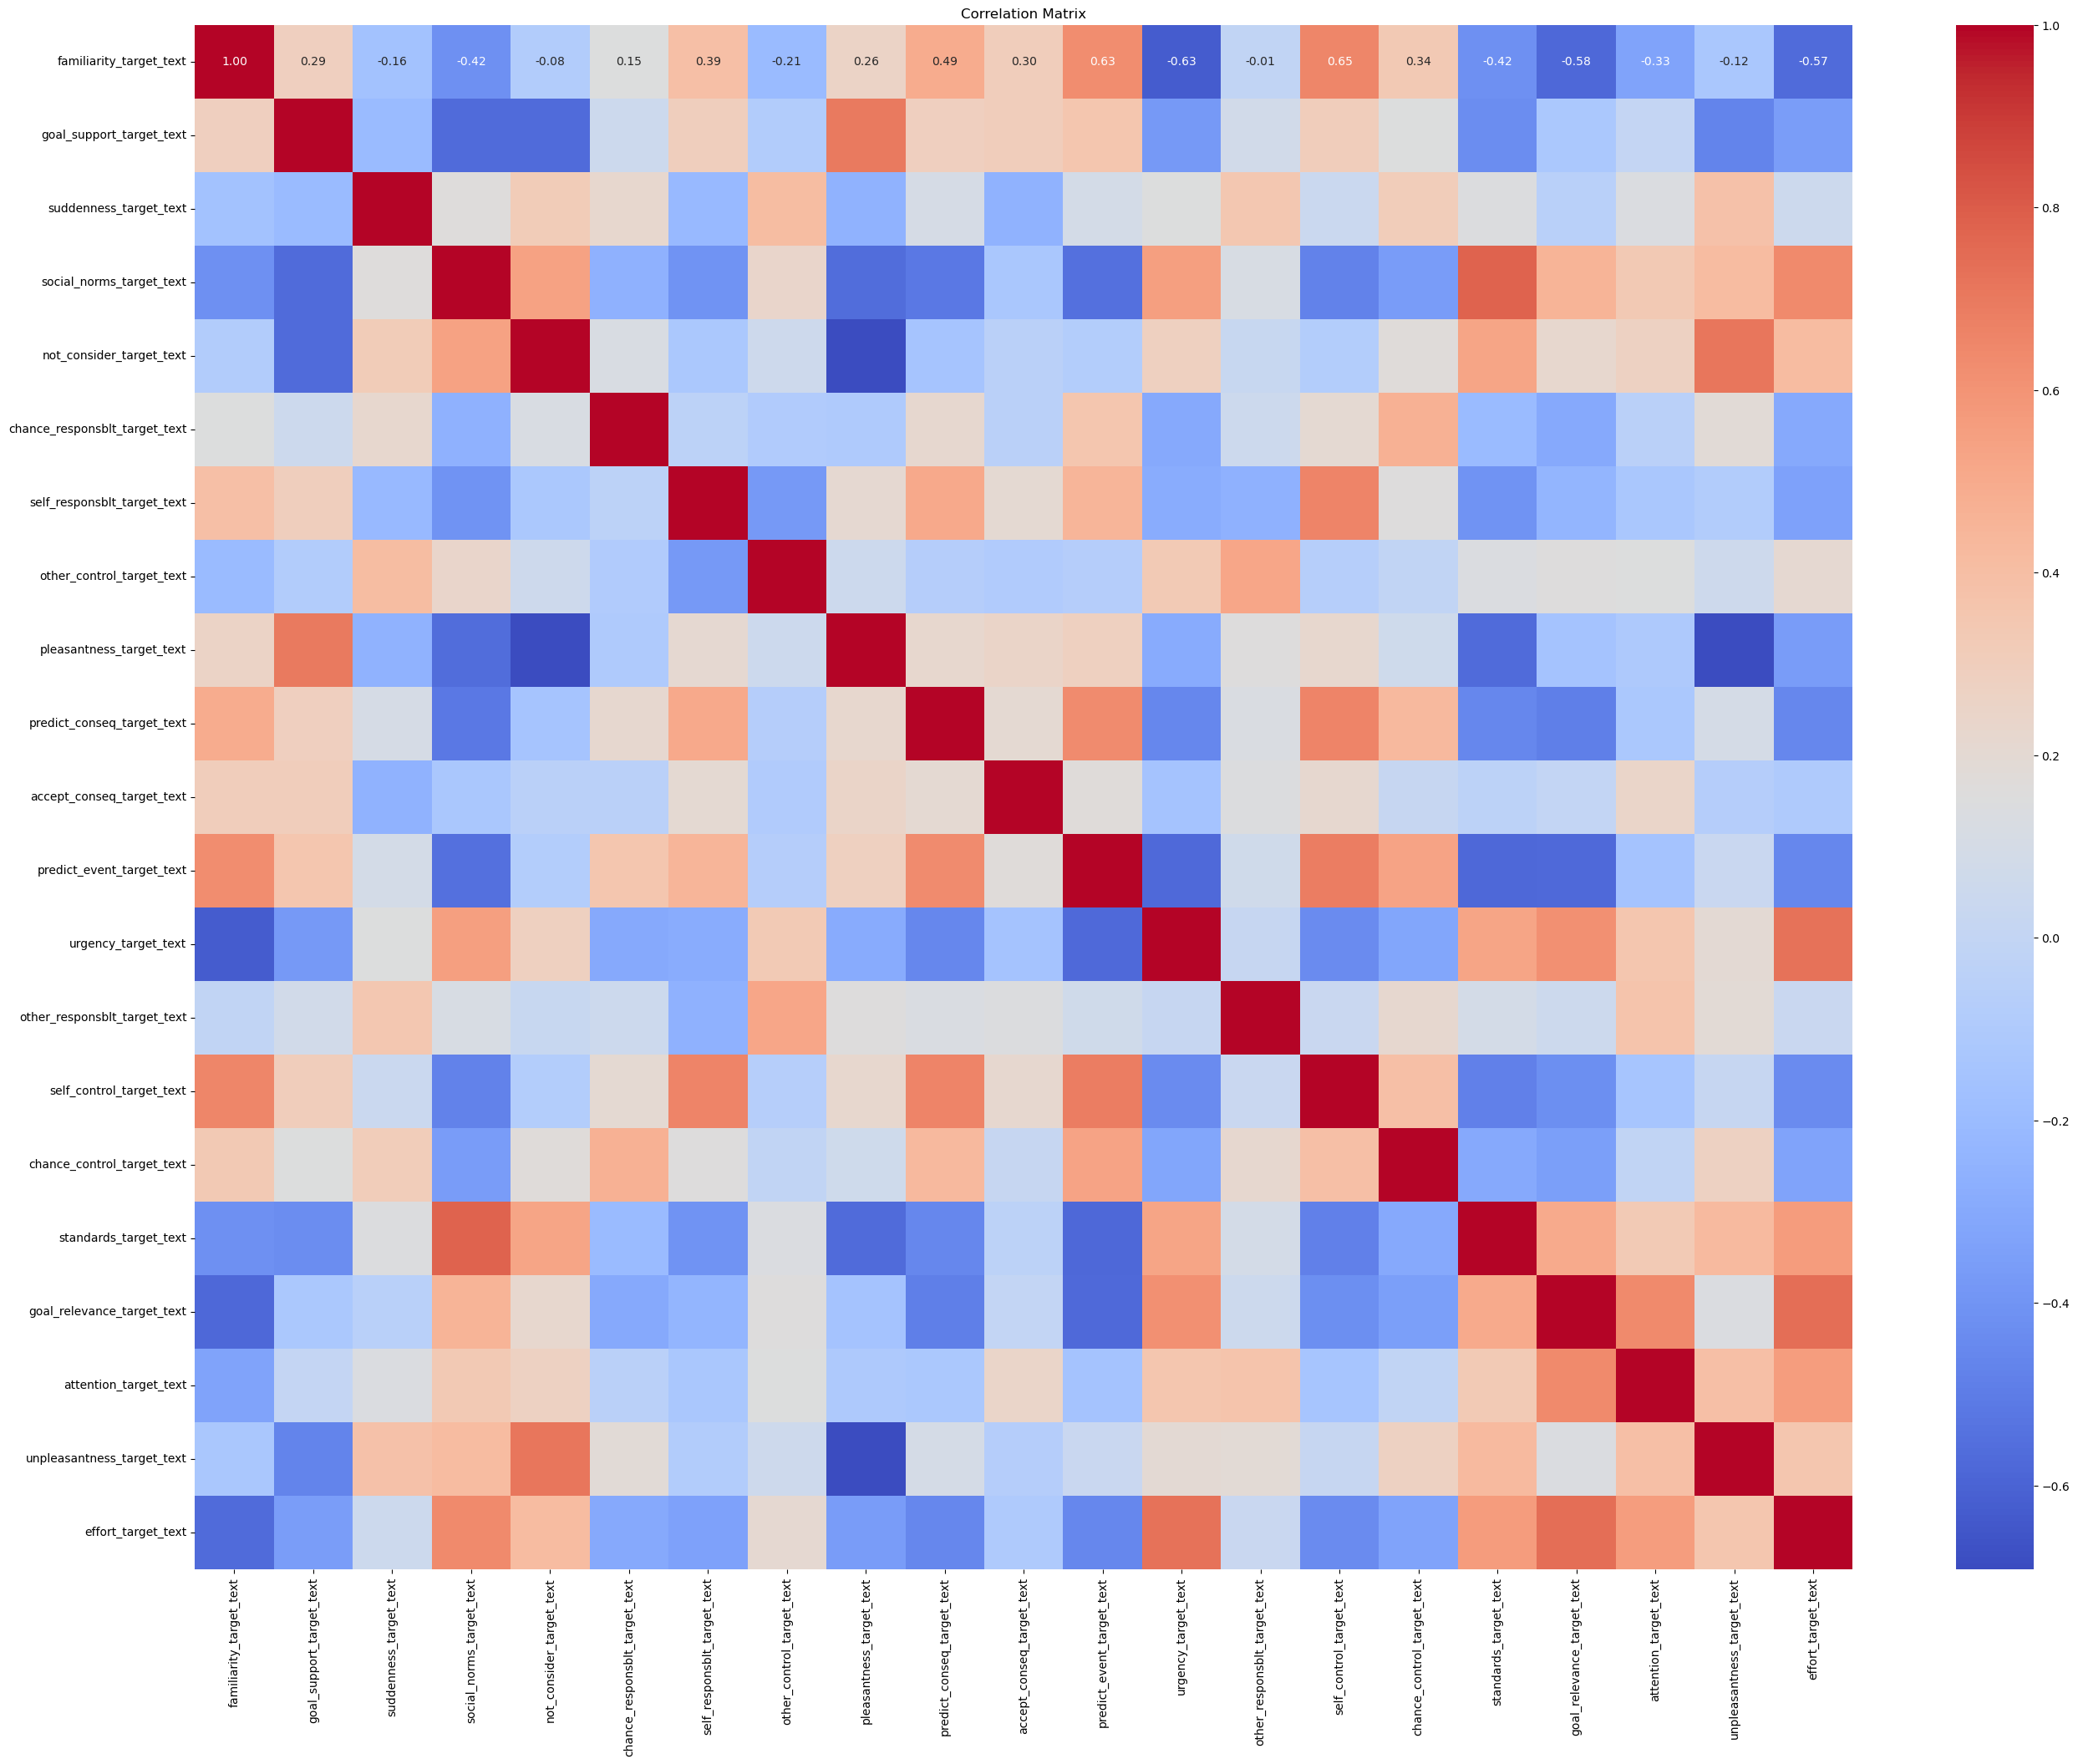

In [65]:
# aloe target text plot
plot_matrix(corr_matrix_aloe_target)

In [66]:
df_aloe_observer = pd.read_csv('./appraised_dialogues/google-t5_ALOE_train.csv')
cols = list(df_aloe_observer.columns)
col_list = []
for col in cols:
    if '_observer_text' in col:
        col_list.append(col)

df_aloe_observer = df_aloe_observer[col_list]
corr_matrix_aloe_observer = df_aloe_observer.corr()
print(corr_matrix_aloe_observer)

                                 familiarity_observer_text  \
familiarity_observer_text                         1.000000   
goal_support_observer_text                        0.487299   
suddenness_observer_text                         -0.279640   
social_norms_observer_text                       -0.587858   
not_consider_observer_text                       -0.316607   
chance_responsblt_observer_text                   0.320766   
self_responsblt_observer_text                     0.480650   
other_control_observer_text                      -0.165555   
pleasantness_observer_text                        0.397006   
predict_conseq_observer_text                      0.703574   
accept_conseq_observer_text                       0.301130   
predict_event_observer_text                       0.680513   
urgency_observer_text                            -0.660758   
other_responsblt_observer_text                    0.267009   
self_control_observer_text                        0.739751   
chance_c

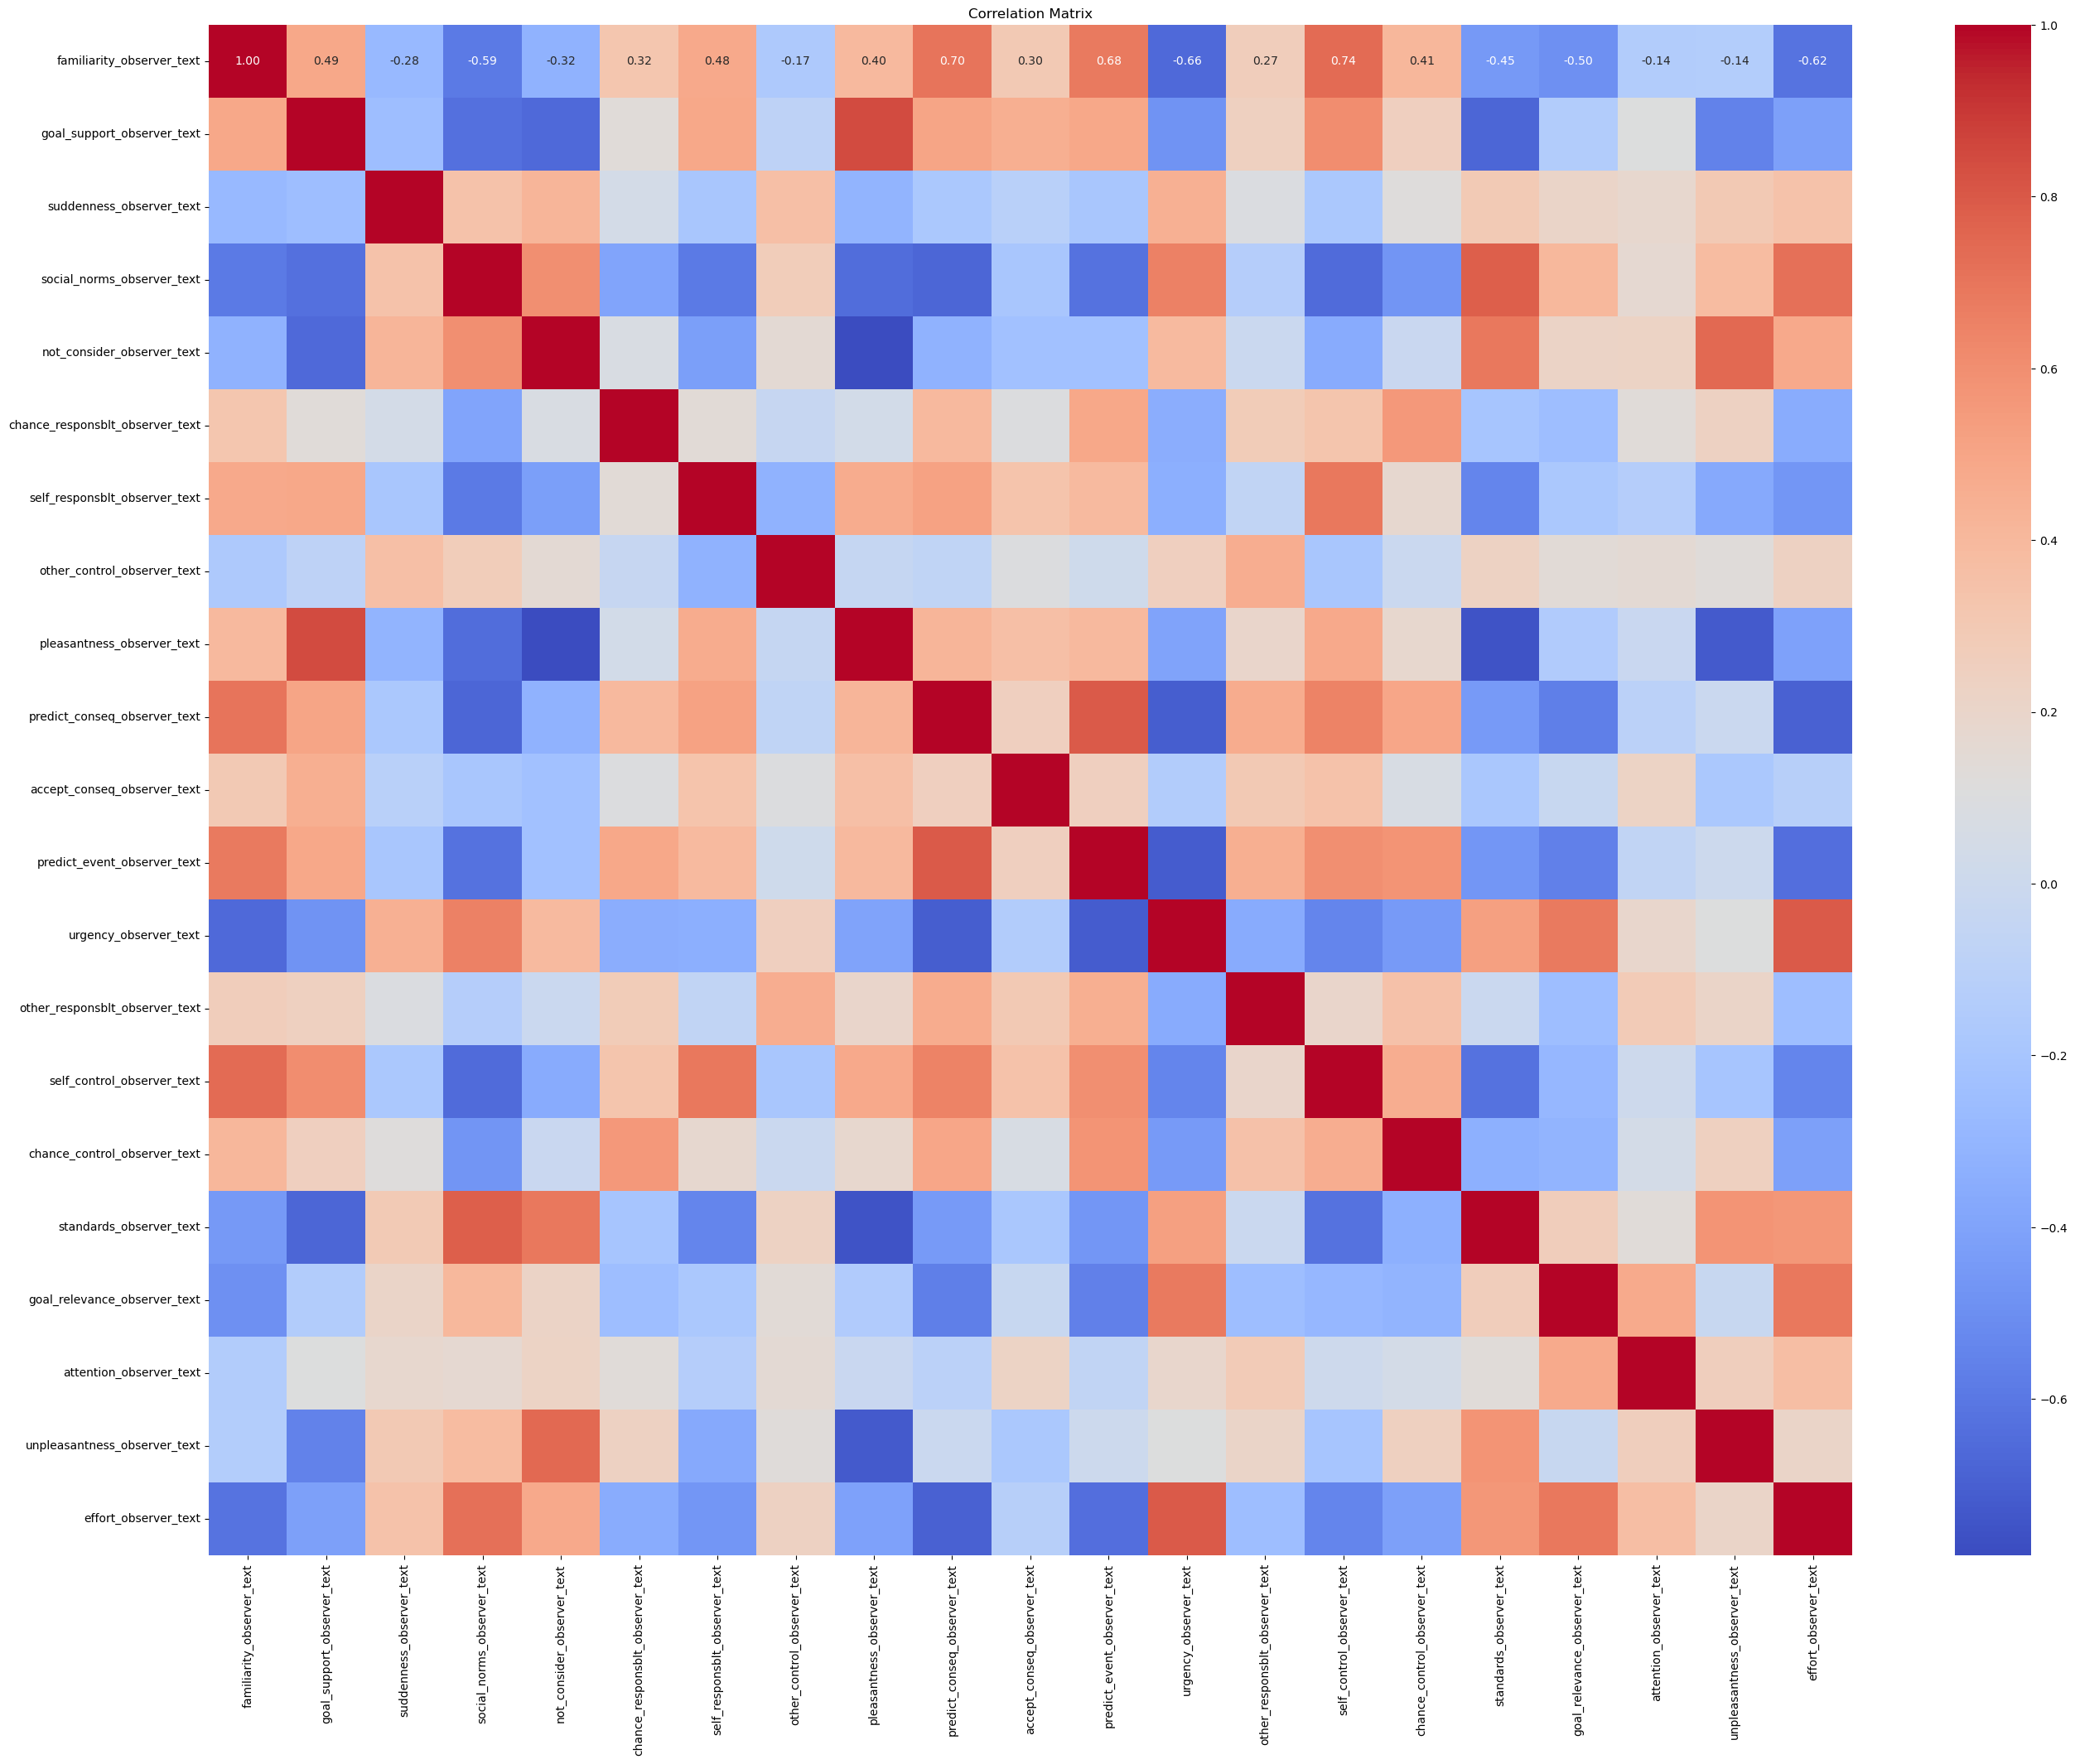

In [67]:
# aloe observer text plot
plot_matrix(corr_matrix_aloe_observer)

# Condolence

In [60]:
df_condolence_observer = pd.read_csv('./appraised_dialogues/google-t5_condolence_train.csv')
cols = list(df_condolence_observer.columns)
col_list = []
for col in cols:
    if '_observer' in col:
        col_list.append(col)

df_condolence_observer = df_condolence_observer[col_list]
corr_matrix_condolence_observer = df_condolence_observer.corr()
print(corr_matrix_condolence_observer)

                            familiarity_observer  goal_support_observer  \
familiarity_observer                    1.000000               0.365513   
goal_support_observer                   0.365513               1.000000   
suddenness_observer                    -0.262446              -0.244733   
social_norms_observer                  -0.492047              -0.557473   
not_consider_observer                  -0.222874              -0.580752   
chance_responsblt_observer              0.196957               0.045130   
self_responsblt_observer                0.326376               0.405149   
other_control_observer                 -0.120392              -0.076375   
pleasantness_observer                   0.381412               0.726373   
predict_conseq_observer                 0.447294               0.465852   
accept_conseq_observer                  0.363210               0.521179   
predict_event_observer                  0.610802               0.410916   
urgency_observer         

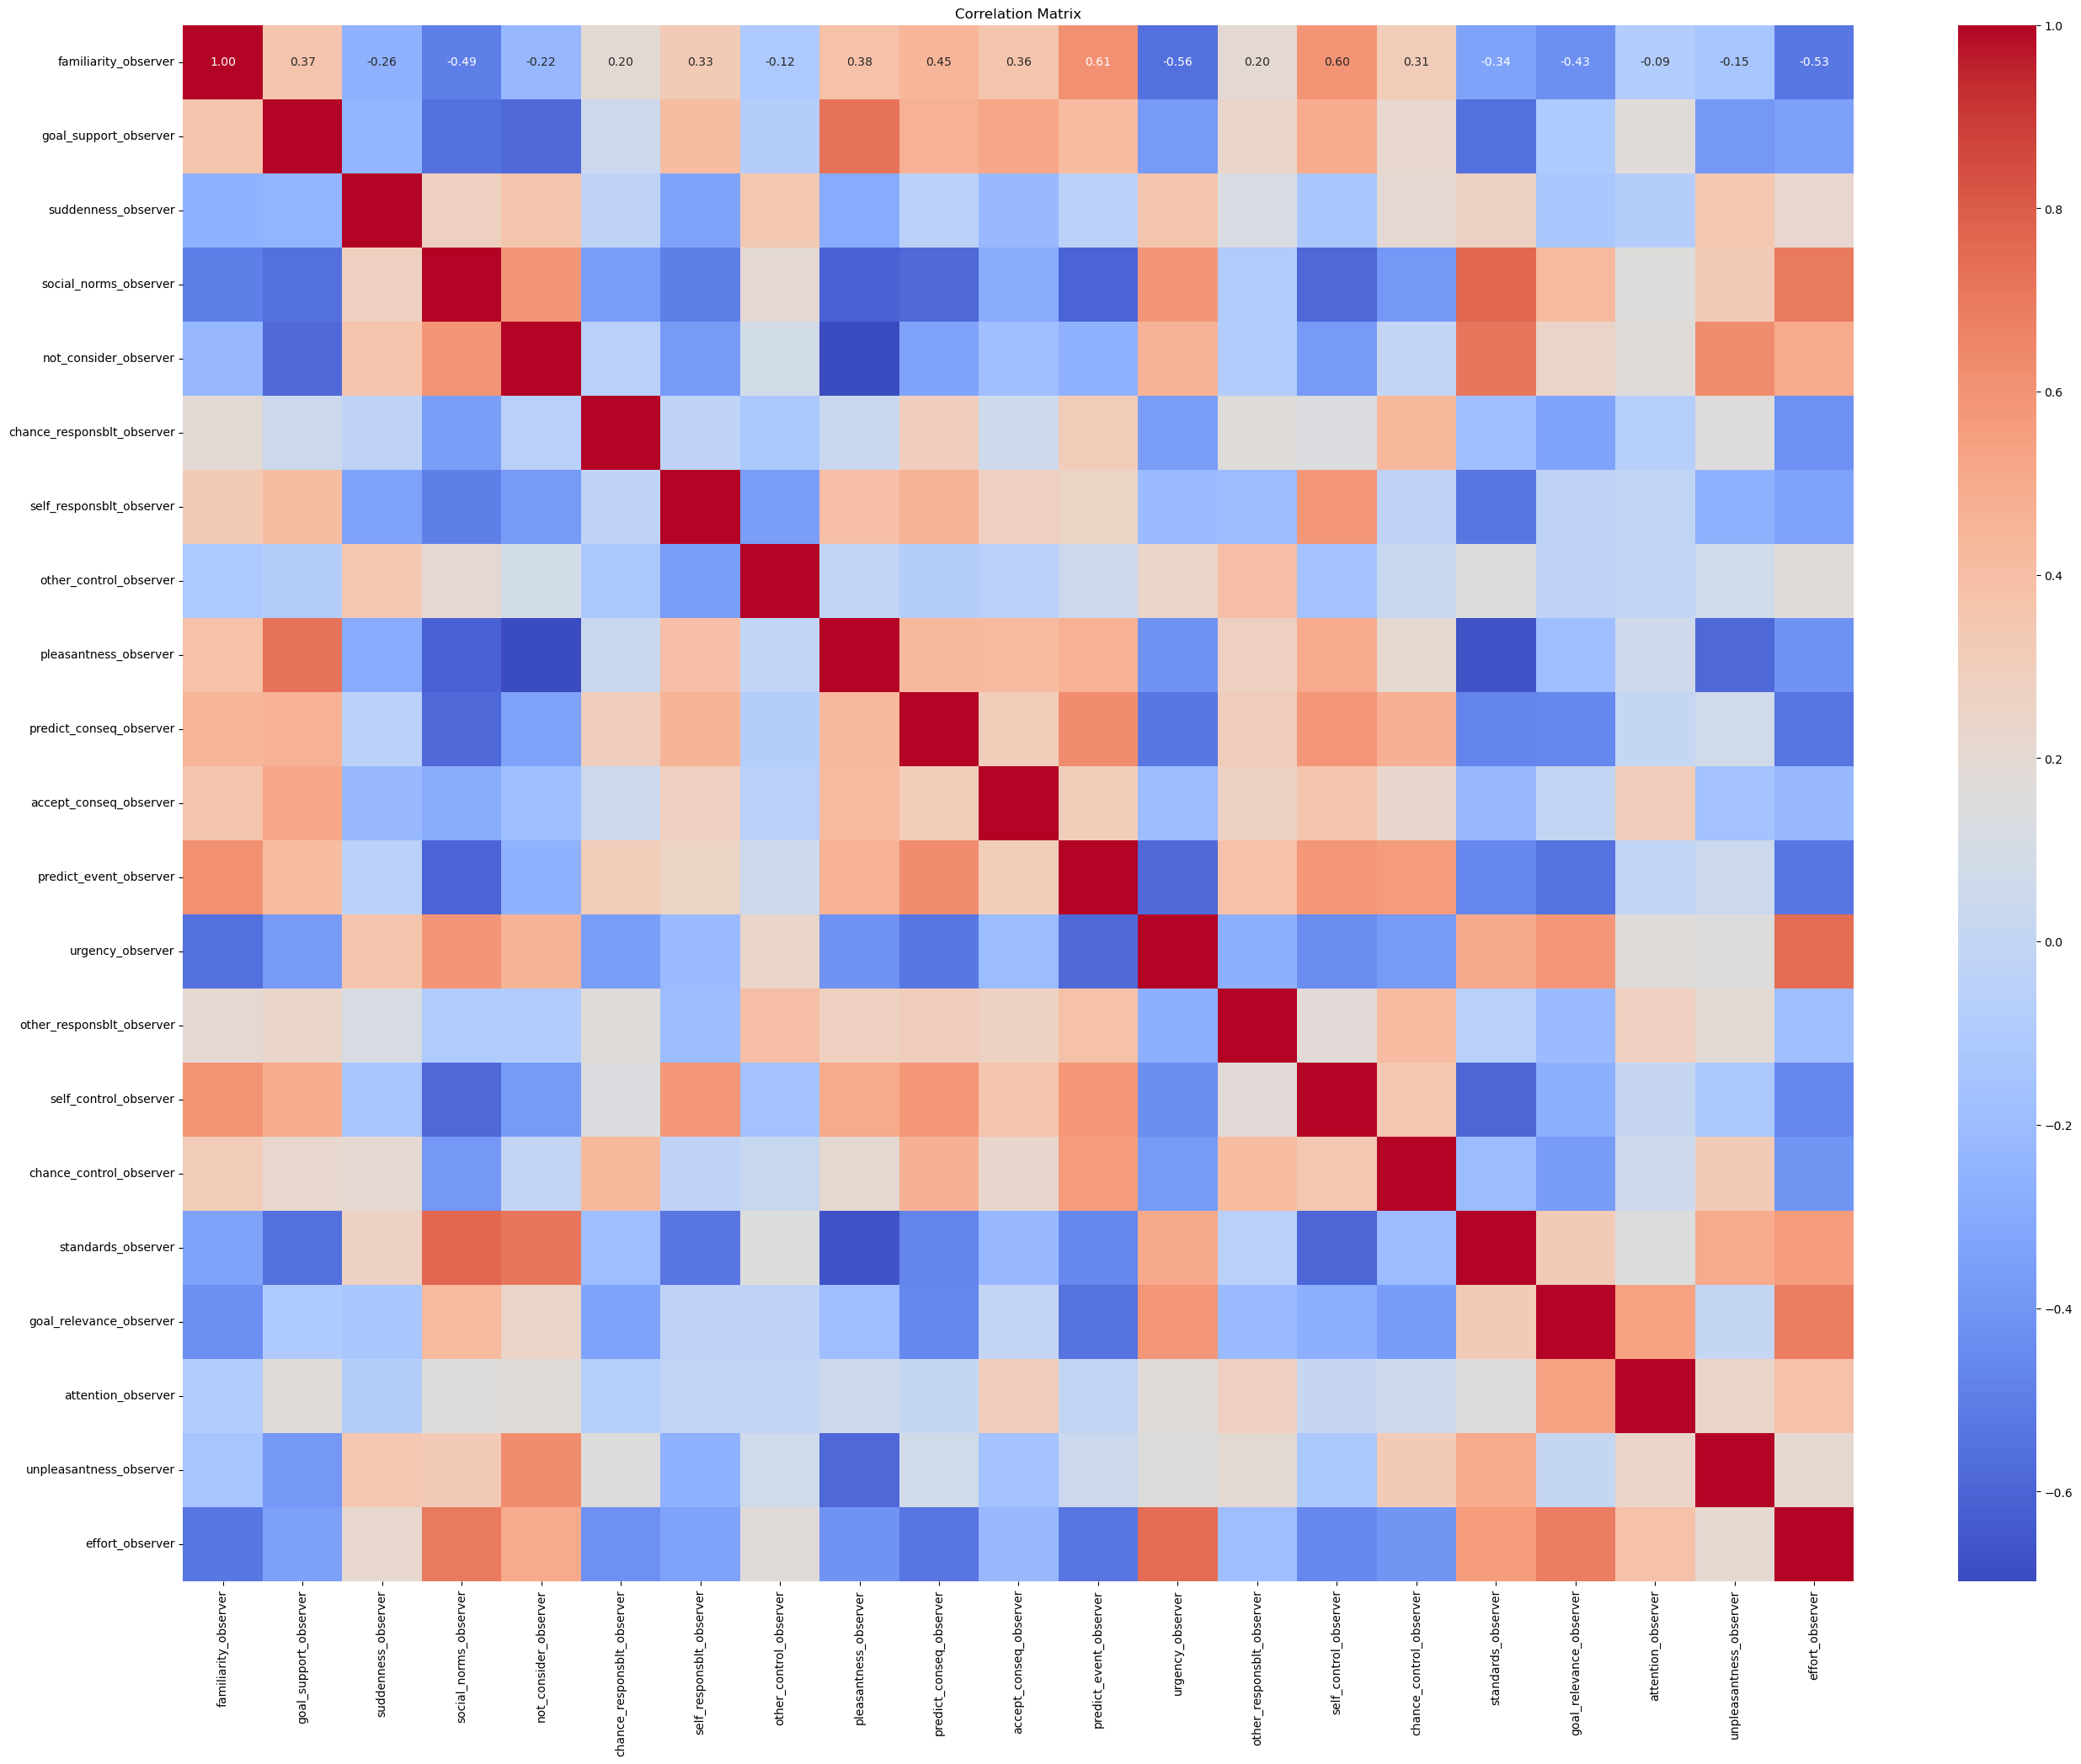

In [61]:
# condolensce observer text plot
plot_matrix(corr_matrix_condolence_observer)

In [62]:
df_condolence_target = pd.read_csv('./appraised_dialogues/google-t5_condolence_train.csv')
cols = list(df_condolence_target.columns)
col_list = []
for col in cols:
    if '_target' in col:
        col_list.append(col)

df_condolence_target = df_condolence_target[col_list]
corr_matrix_condolence_target = df_condolence_target.corr()
print(corr_matrix_condolence_target)

                          familiarity_target  goal_support_target  \
familiarity_target                  1.000000             0.388667   
goal_support_target                 0.388667             1.000000   
suddenness_target                  -0.229359            -0.269181   
social_norms_target                -0.365987            -0.465330   
not_consider_target                -0.108446            -0.512754   
chance_responsblt_target            0.011426             0.018857   
self_responsblt_target              0.450908             0.374129   
other_control_target               -0.090409             0.036626   
pleasantness_target                 0.260952             0.616059   
predict_conseq_target               0.380749             0.391350   
accept_conseq_target                0.262138             0.429818   
predict_event_target                0.620224             0.386735   
urgency_target                     -0.578243            -0.338380   
other_responsblt_target           

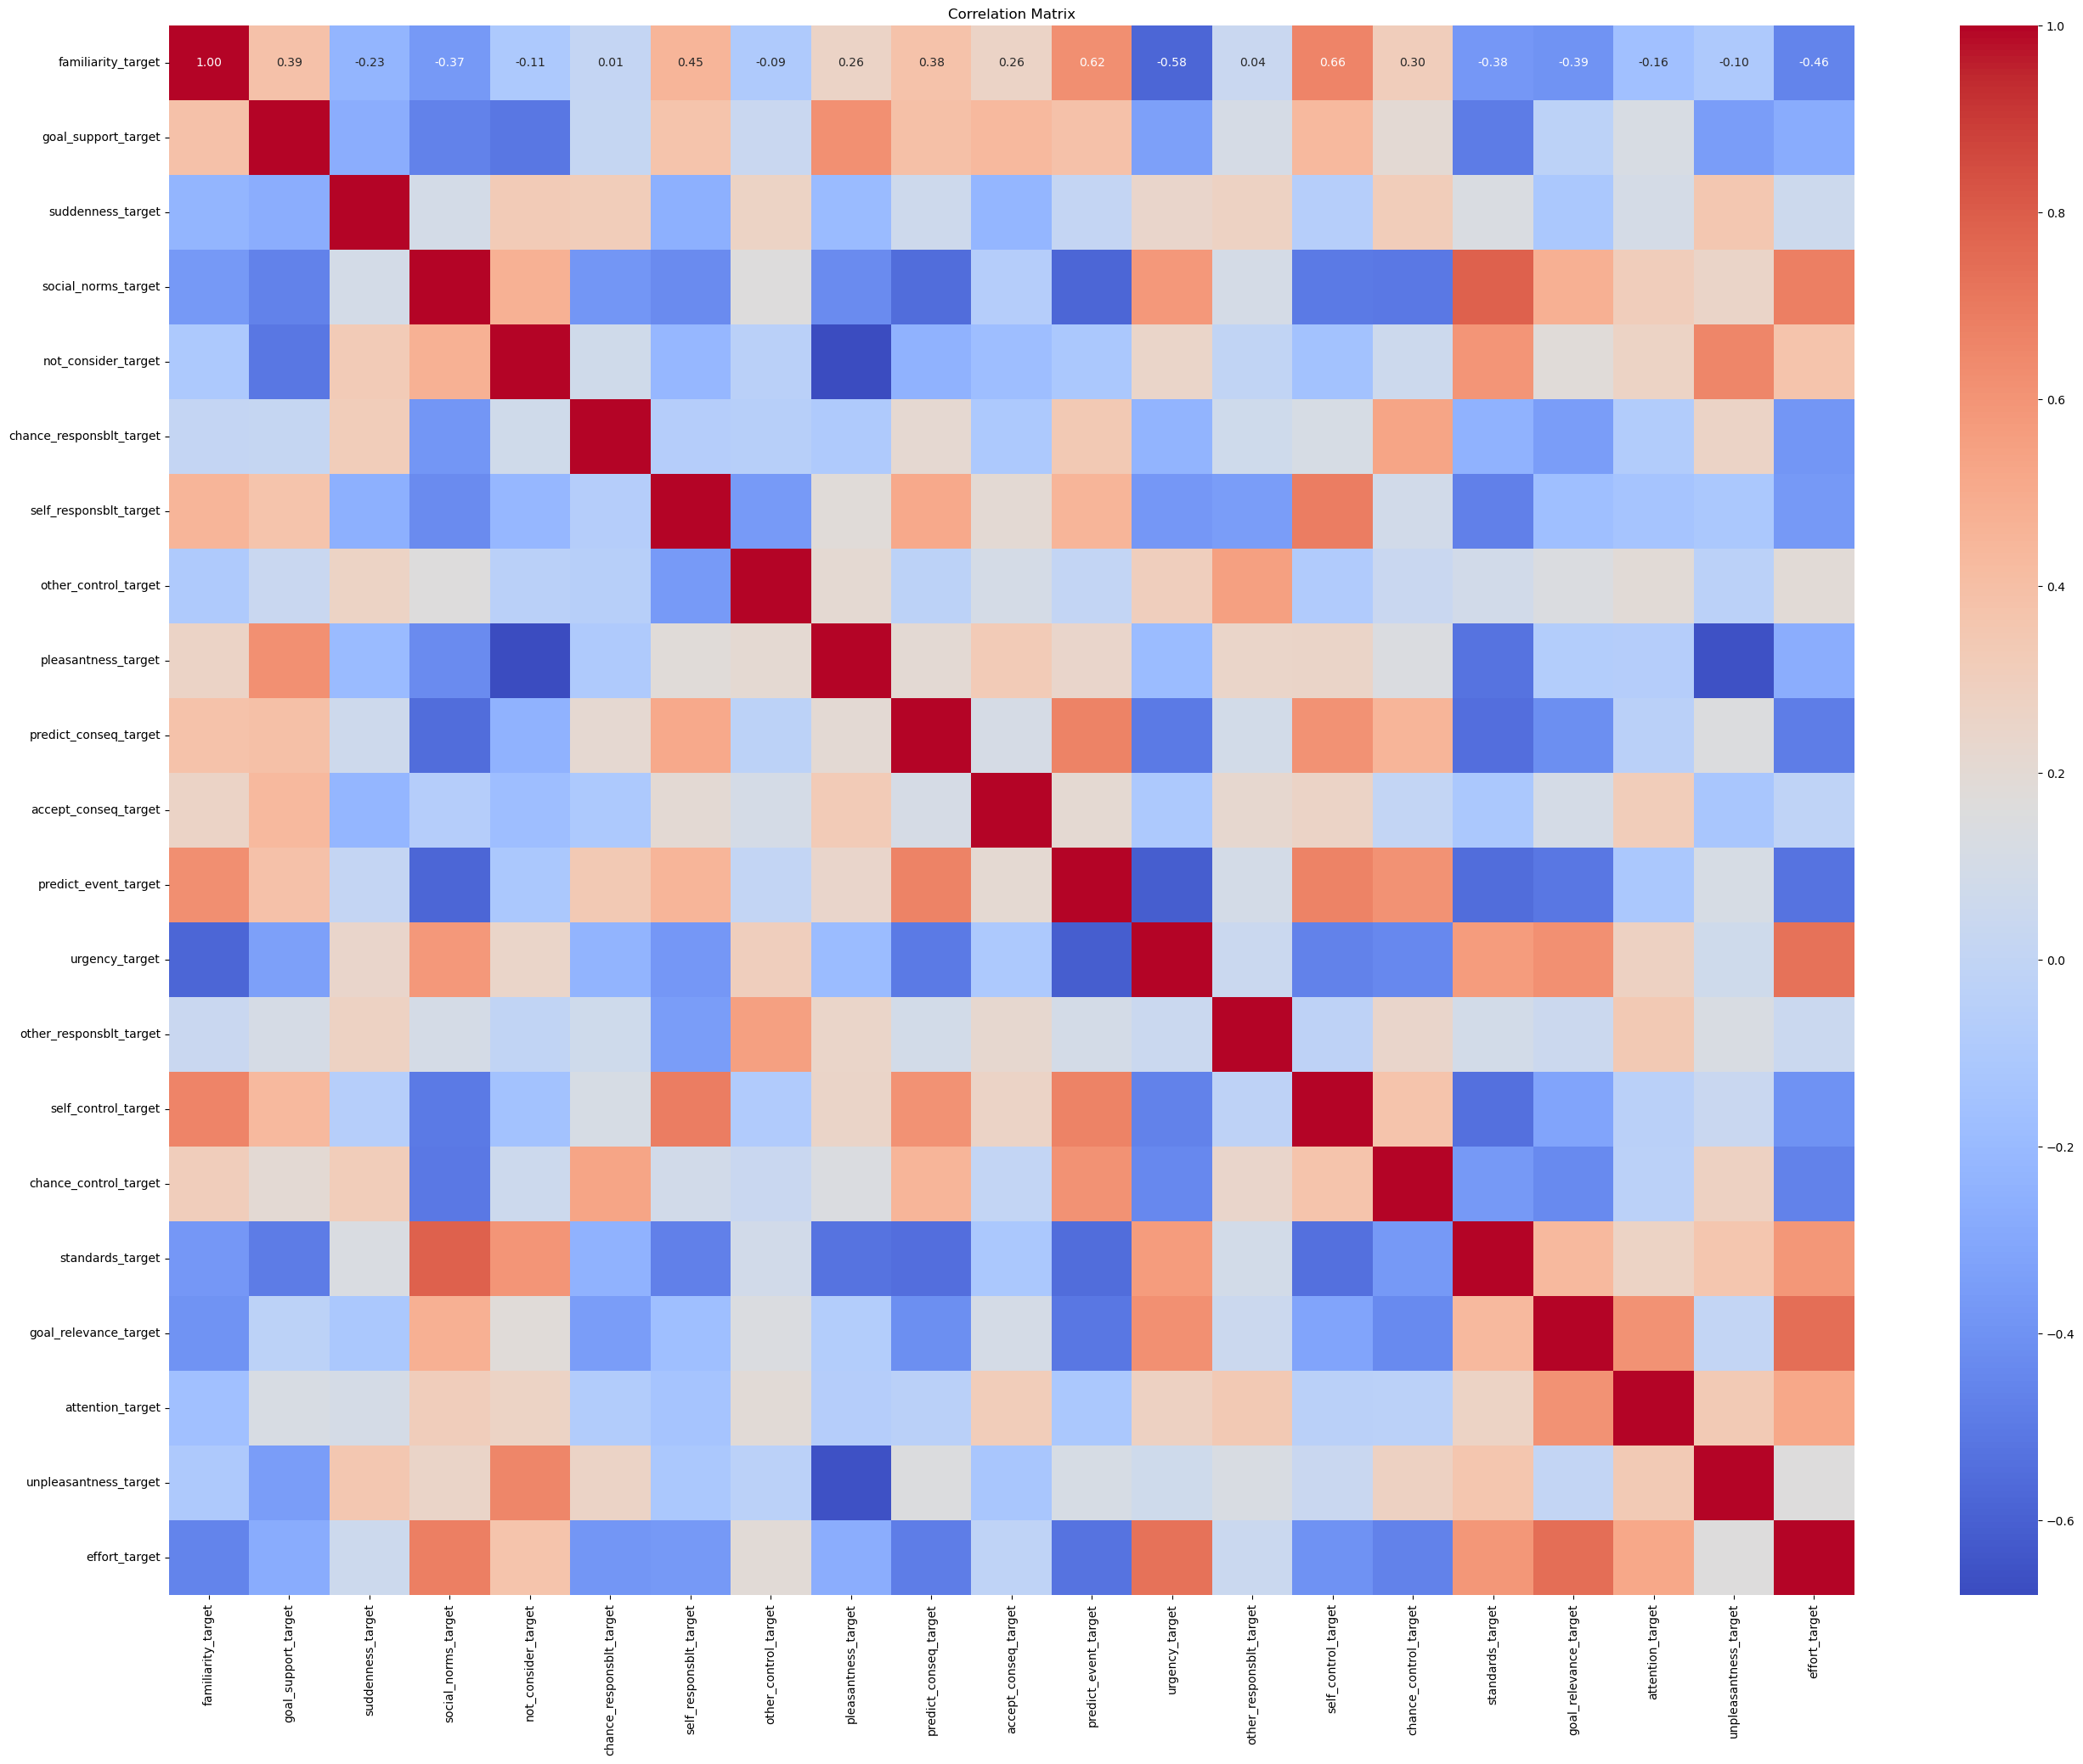

In [63]:
# condolensce target text plot
plot_matrix(corr_matrix_condolence_target)

# EPITOME

In [13]:
df_epitome_seeker = pd.read_csv('./appraised_dialogues/google-t5_epitome_train.csv')
cols = list(df_epitome_seeker.columns)
# cols
col_list = []
for col in cols:
    if '_seeker' in col:
        col_list.append(col)

df_epitome_seeker = df_epitome_seeker[col_list]
corr_matrix_epitome_seeker = df_epitome_seeker.corr()
print(corr_matrix_epitome_seeker)

                          familiarity_seeker  goal_support_seeker  \
familiarity_seeker                  1.000000             0.191058   
goal_support_seeker                 0.191058             1.000000   
suddenness_seeker                  -0.219320            -0.202229   
social_norms_seeker                -0.144350            -0.587138   
not_consider_seeker                 0.029968            -0.602155   
chance_responsblt_seeker           -0.051460            -0.140026   
self_responsblt_seeker              0.270300             0.312619   
other_control_seeker               -0.203789             0.020234   
pleasantness_seeker                 0.032806             0.754195   
predict_conseq_seeker               0.316197             0.213451   
accept_conseq_seeker                0.173451             0.377254   
predict_event_seeker                0.414915             0.295834   
urgency_seeker                     -0.307186            -0.177825   
other_responsblt_seeker           

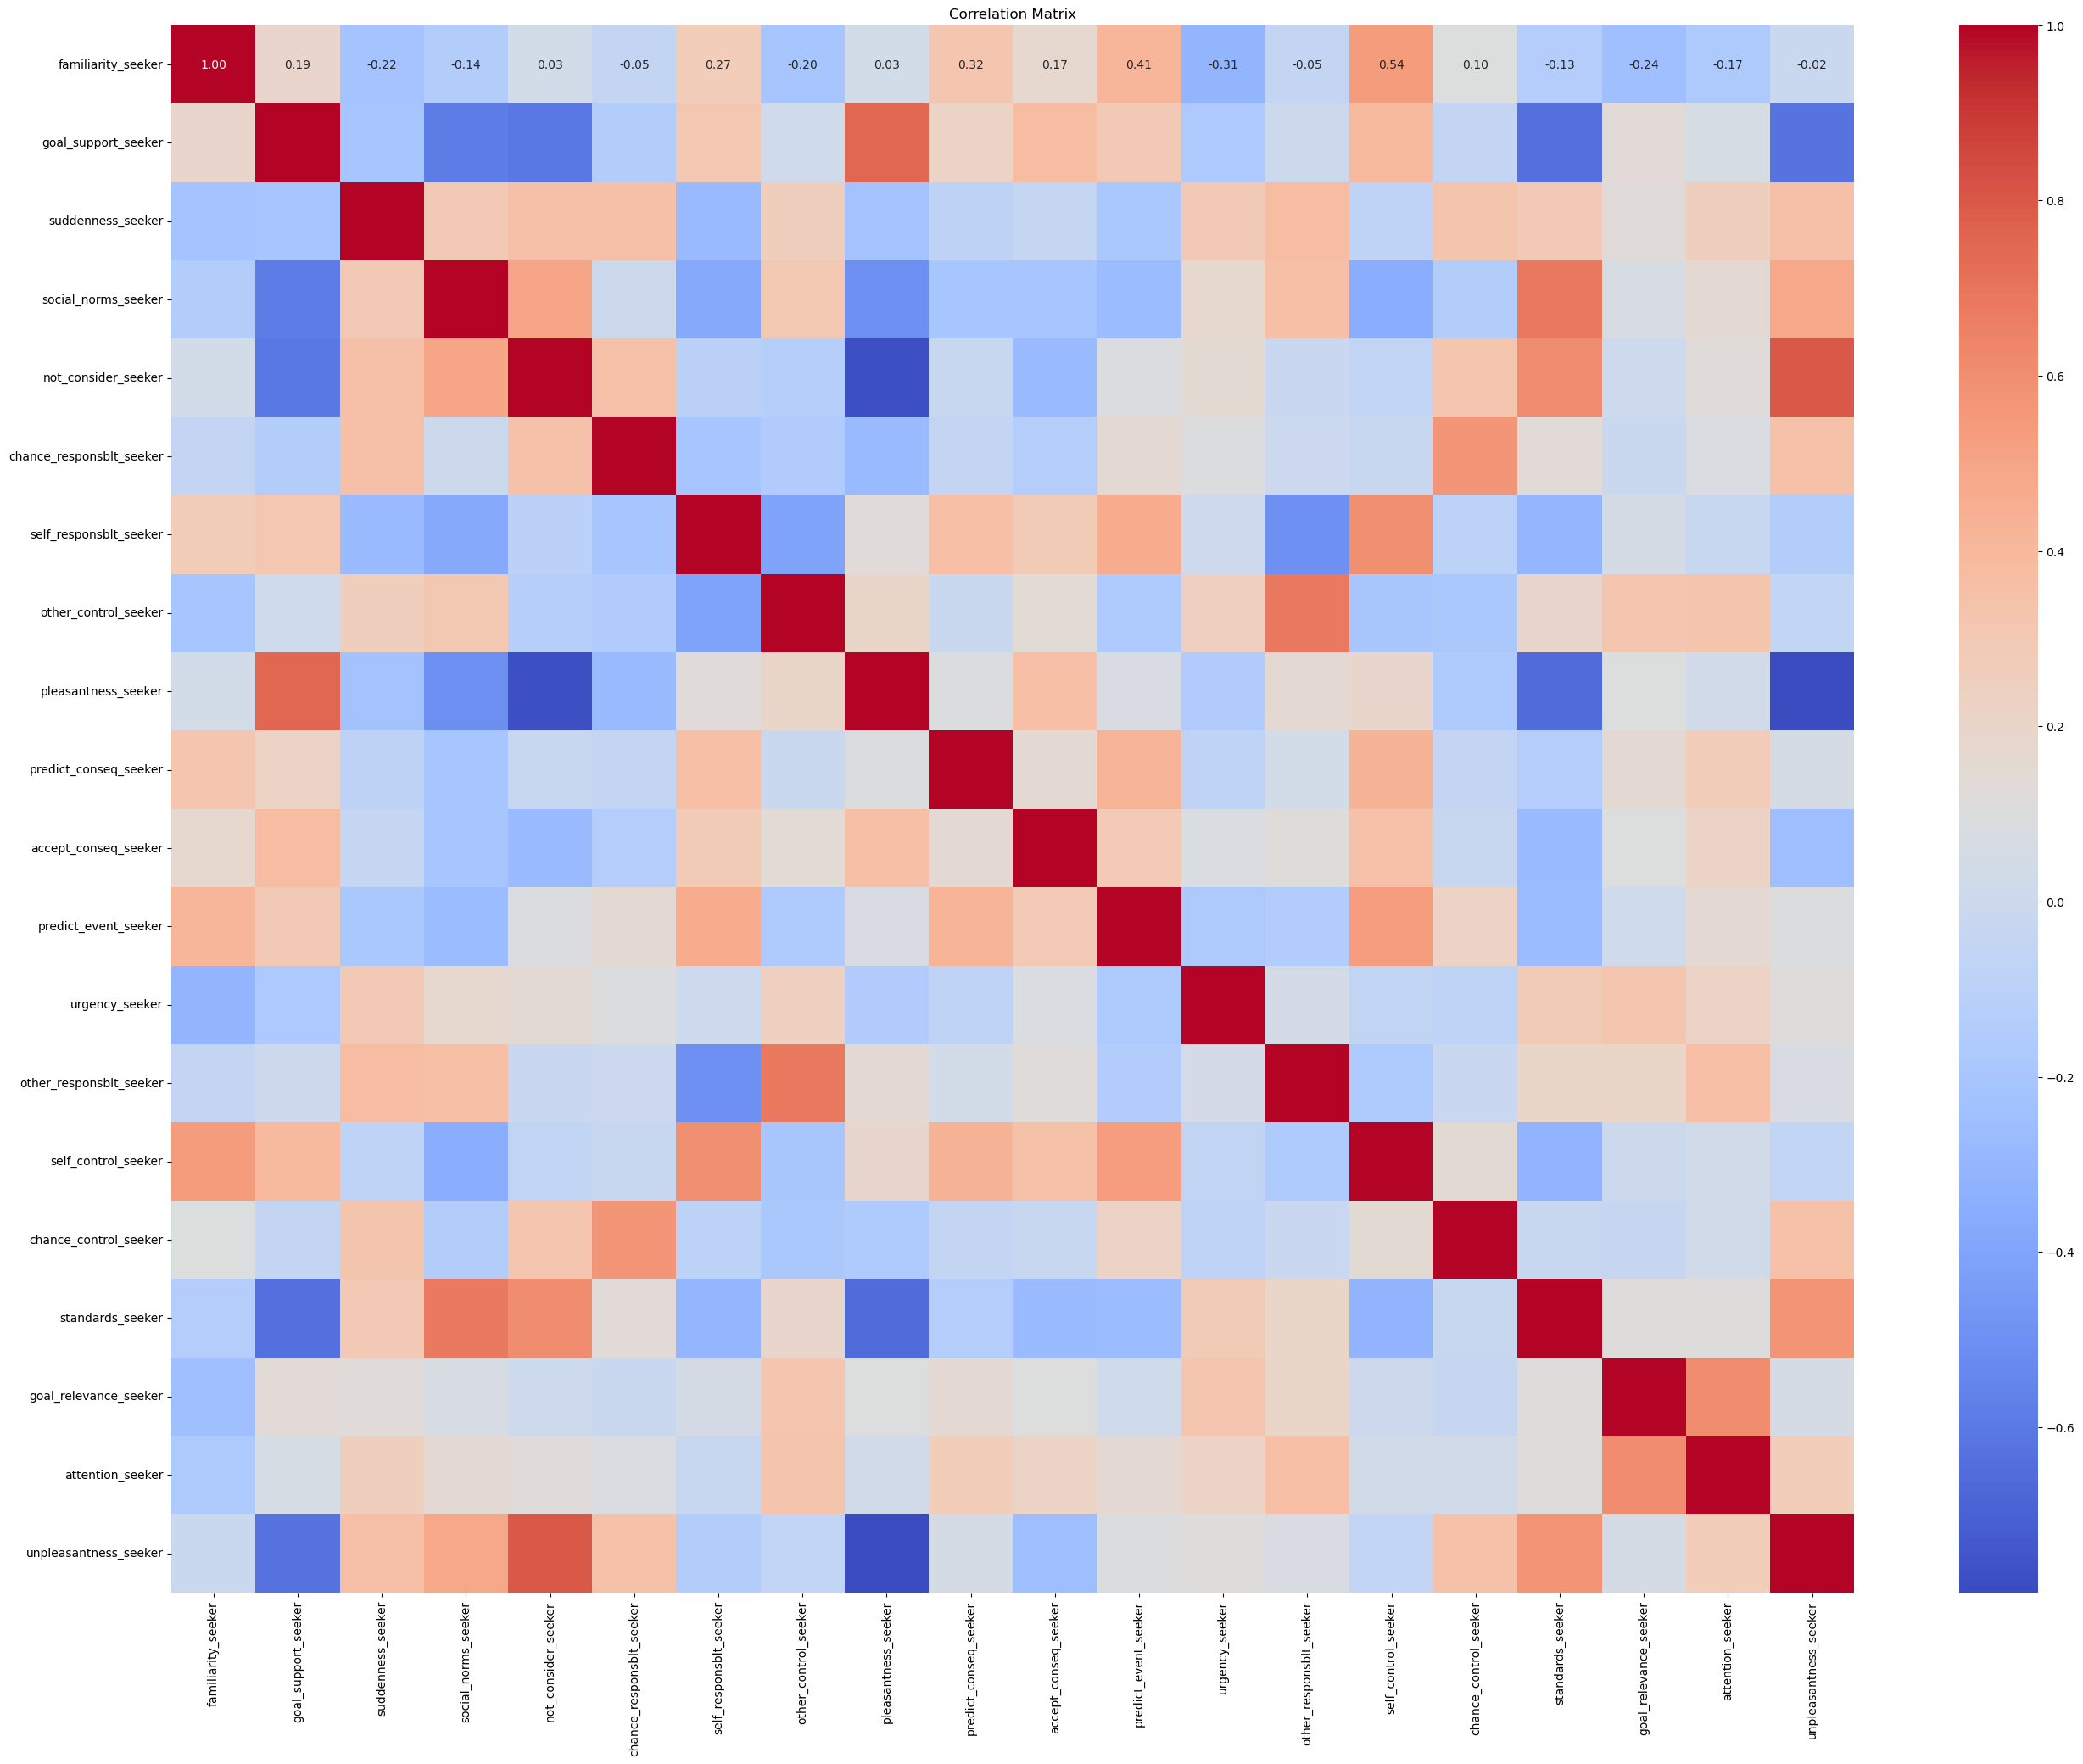

In [14]:
# epitome seeker text plot
plot_matrix(corr_matrix_epitome_seeker)

In [16]:
df_epitome_response = pd.read_csv('./appraised_dialogues/google-t5_epitome_train.csv')
cols = list(df_epitome_response.columns)
# cols
col_list = []
for col in cols:
    if '_response' in col:
        col_list.append(col)

df_epitome_response = df_epitome_response[col_list]
corr_matrix_epitome_response = df_epitome_response.corr()
print(corr_matrix_epitome_response)

                            familiarity_response  goal_support_response  \
familiarity_response                    1.000000               0.270314   
goal_support_response                   0.270314               1.000000   
suddenness_response                    -0.275114              -0.326517   
social_norms_response                  -0.294341              -0.677390   
not_consider_response                  -0.162302              -0.714908   
chance_responsblt_response             -0.014171              -0.160211   
self_responsblt_response                0.372539               0.422696   
other_control_response                 -0.167248               0.127381   
pleasantness_response                   0.179837               0.815078   
predict_conseq_response                 0.466090               0.387677   
accept_conseq_response                  0.230214               0.517832   
predict_event_response                  0.533287               0.453807   
urgency_response         

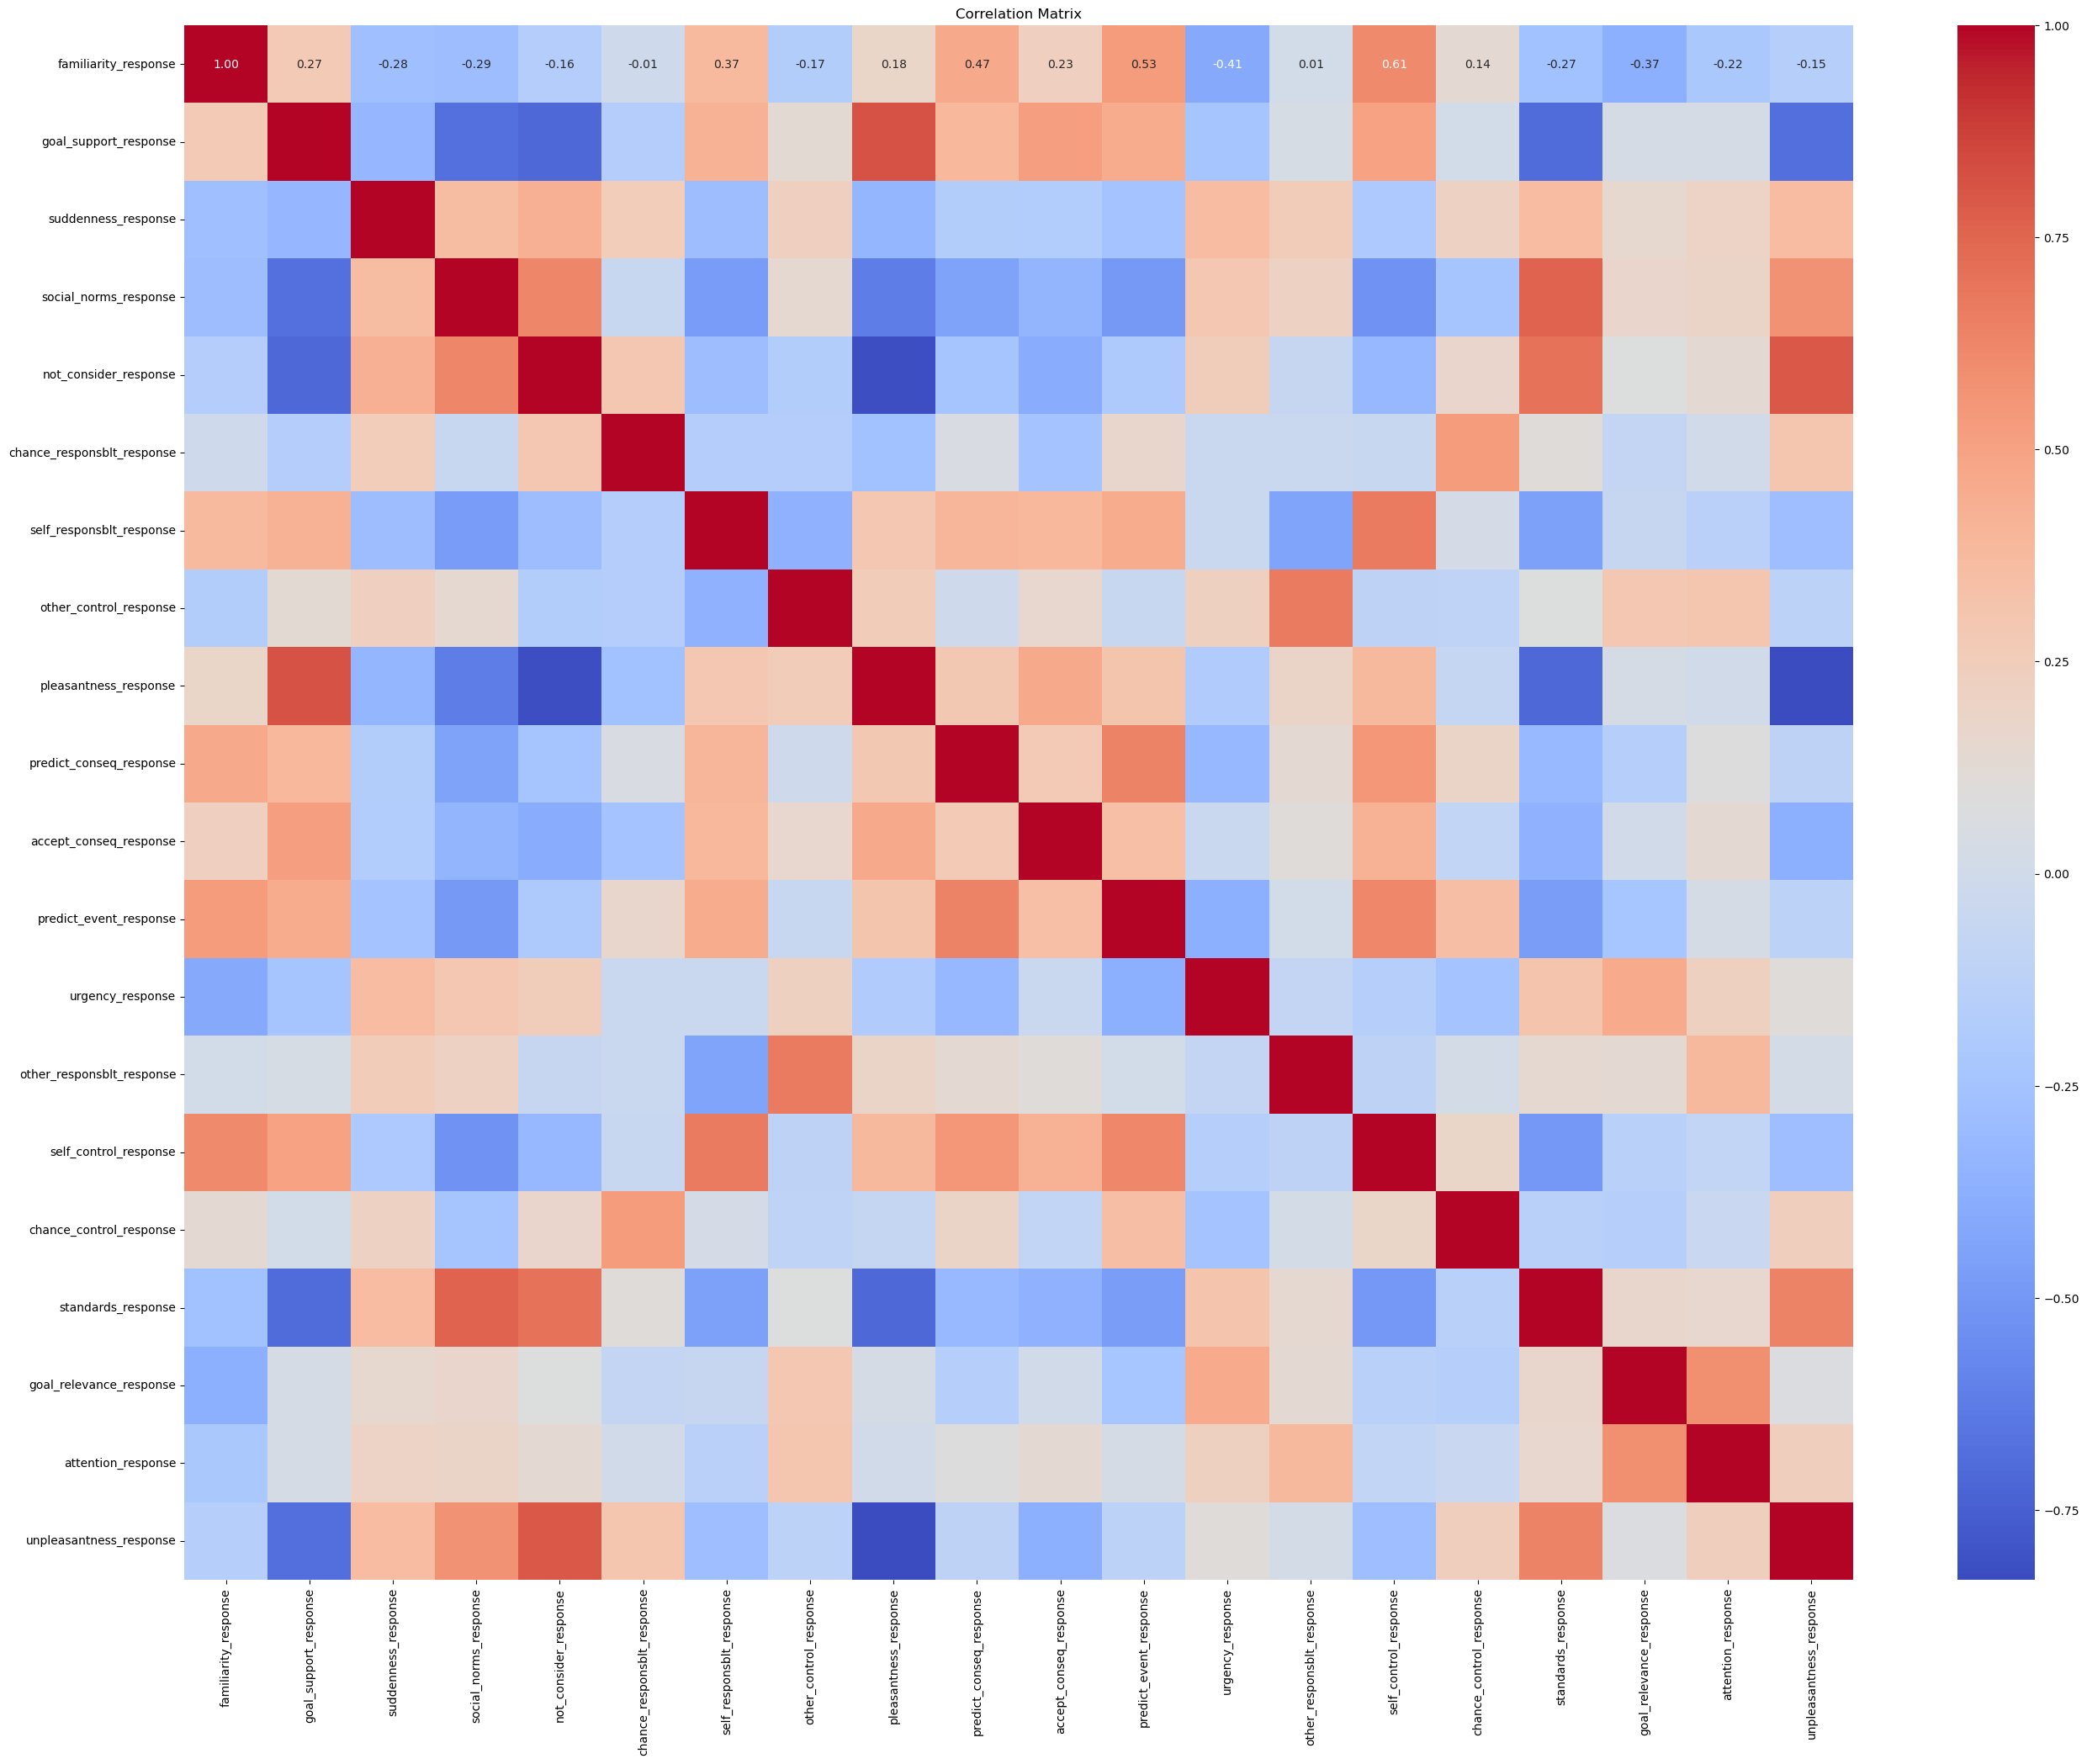

In [17]:
# epitome response text plot
plot_matrix(corr_matrix_epitome_response)

# Empathetic Dialogues

In [34]:
df_empdial_sp1 = pd.read_csv('./appraised_dialogues/google-t5_empdial_train.csv')
cols = list(df_empdial_sp1.columns)
# cols
col_list = []
for col in cols:
    if '_sp1' in col:
        col_list.append(col)

df_empdial_sp1 = df_empdial_sp1[col_list]
corr_matrix_empdial_sp1 = df_empdial_sp1.corr()
print(corr_matrix_empdial_sp1)

                       familiarity_sp1  goal_support_sp1  suddenness_sp1  \
familiarity_sp1               1.000000          0.204827       -0.522852   
goal_support_sp1              0.204827          1.000000       -0.550450   
suddenness_sp1               -0.522852         -0.550450        1.000000   
social_norms_sp1             -0.175571         -0.803577        0.590988   
not_consider_sp1             -0.183761         -0.847509        0.556405   
chance_responsblt_sp1        -0.325219         -0.425500        0.480404   
self_responsblt_sp1           0.401947          0.517489       -0.591797   
other_control_sp1            -0.249056          0.074287        0.298121   
pleasantness_sp1              0.245799          0.872293       -0.502521   
predict_conseq_sp1            0.356479          0.466790       -0.428883   
accept_conseq_sp1             0.170781          0.579540       -0.335467   
predict_event_sp1             0.441933          0.544016       -0.592762   
urgency_sp1 

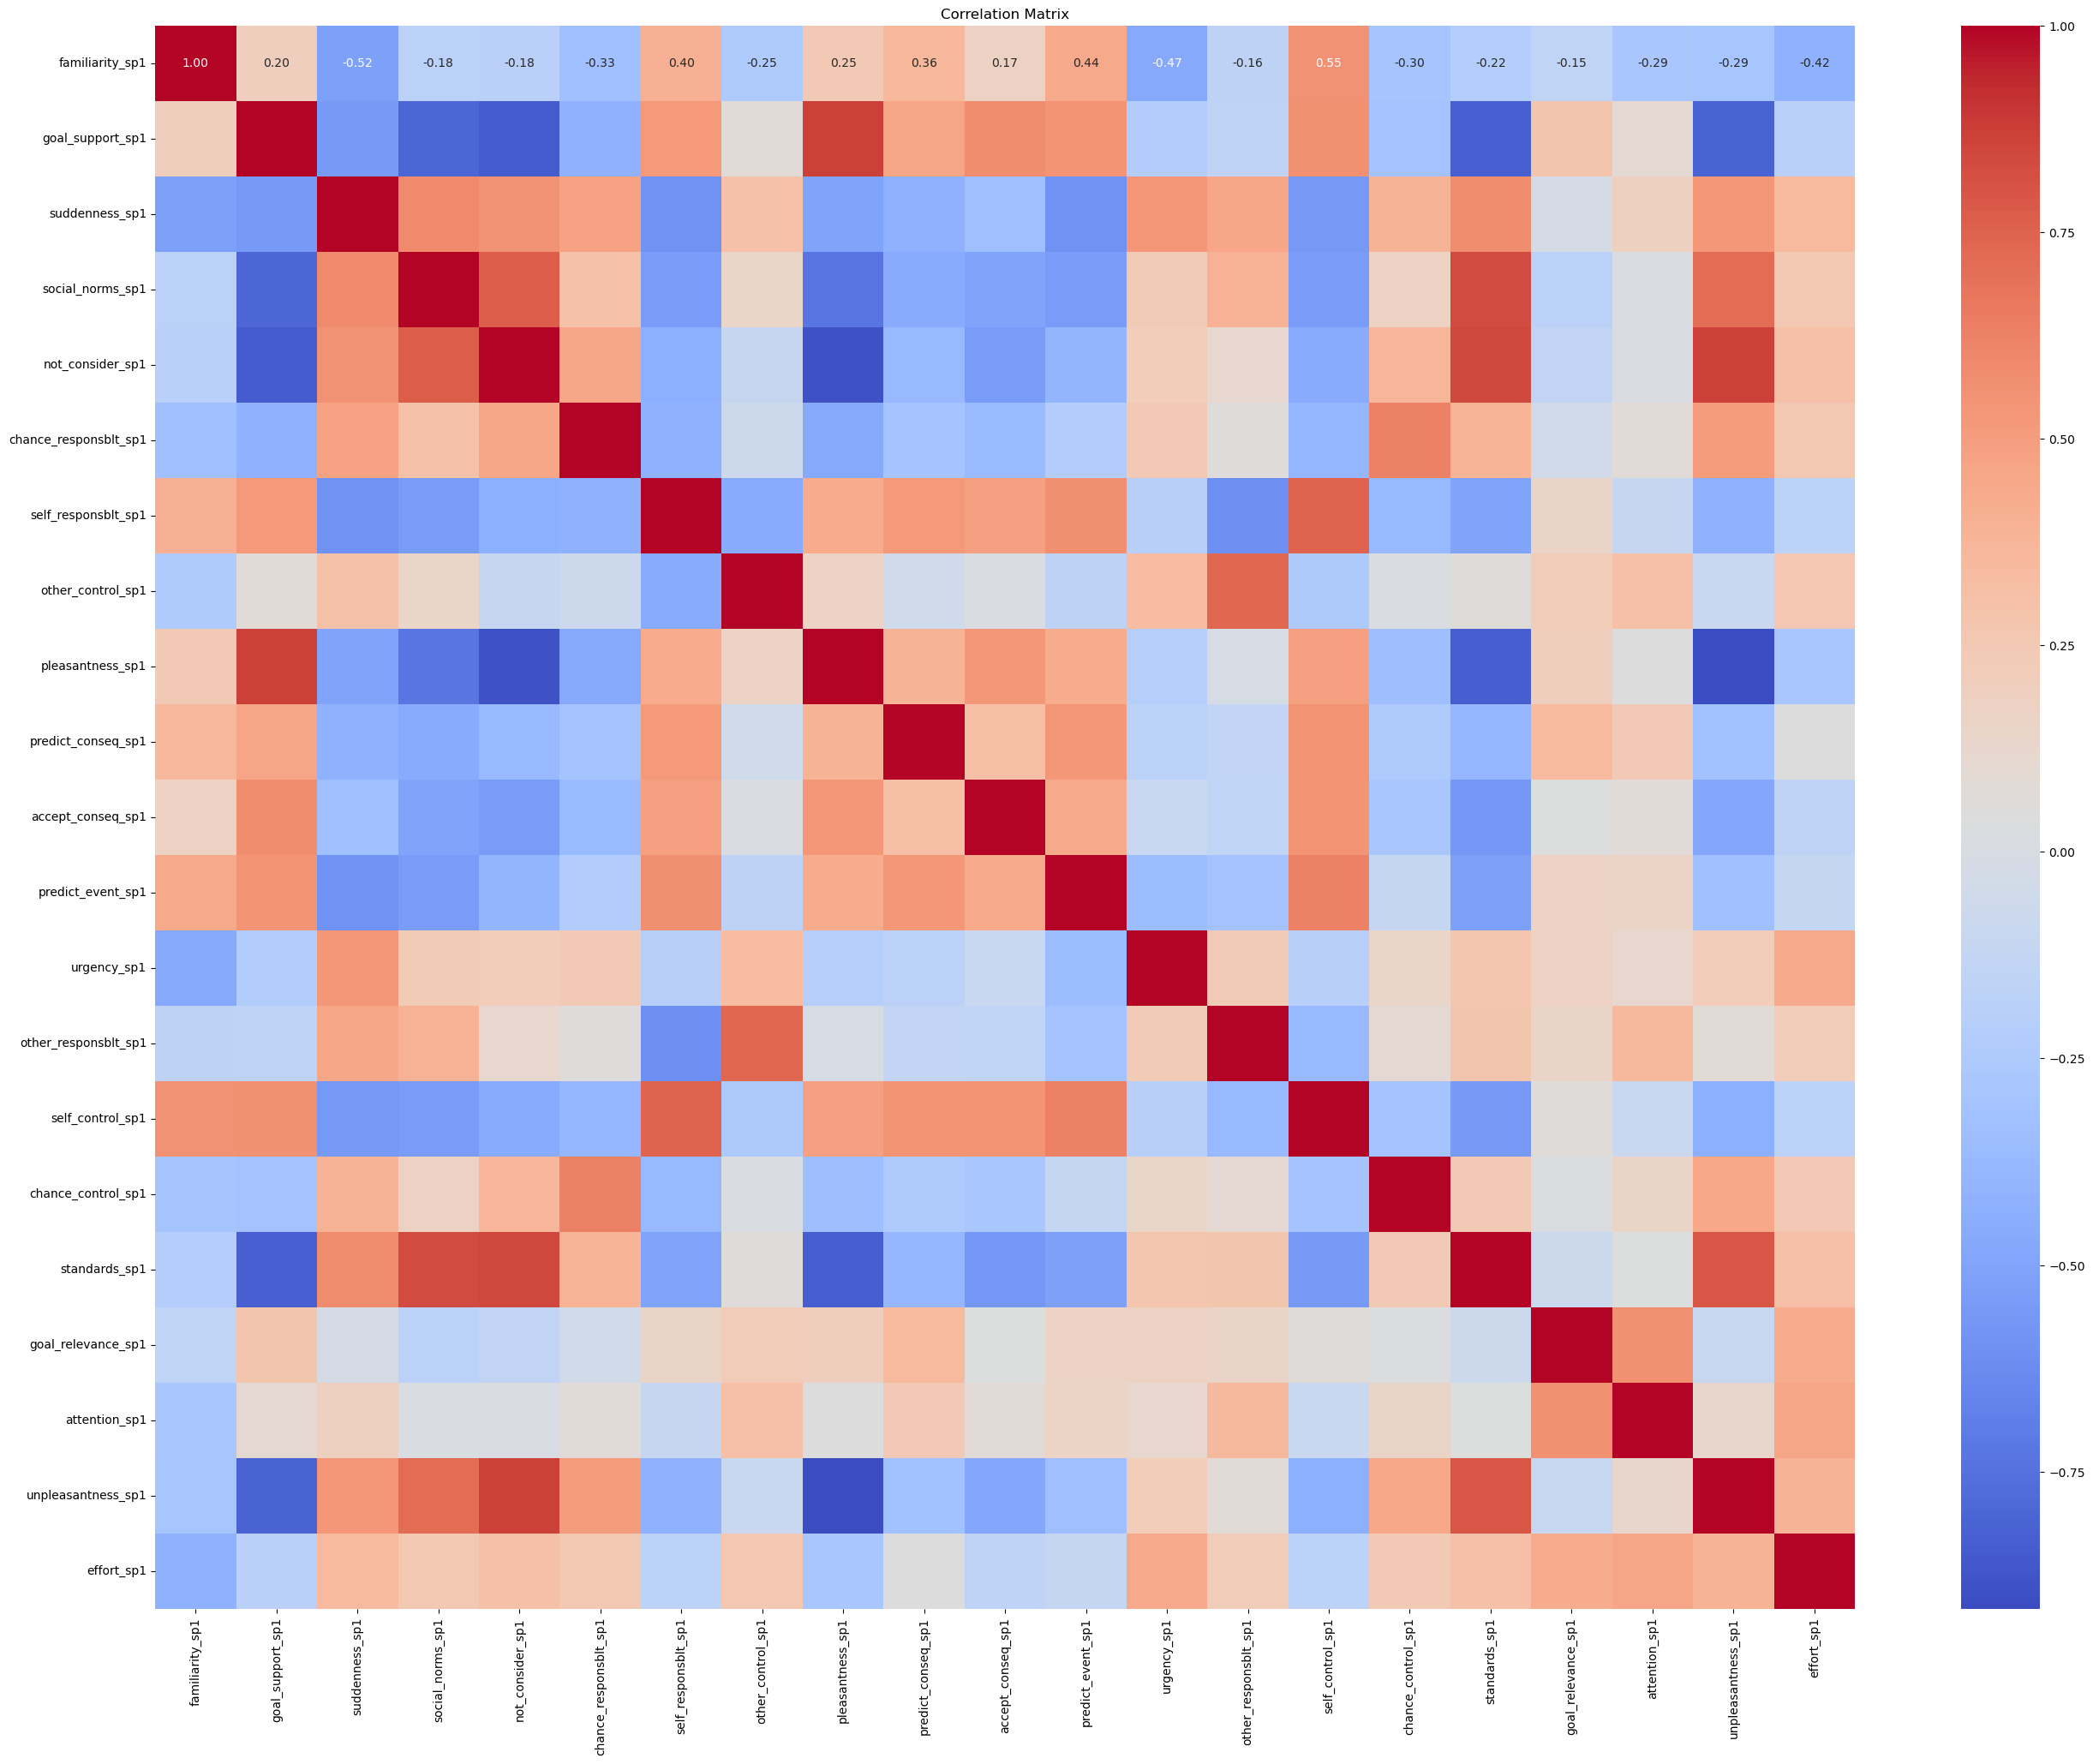

In [35]:
# emp-dial seeker text plot
plot_matrix(corr_matrix_empdial_sp1)

In [36]:
df_empdial_sp2 = pd.read_csv('./appraised_dialogues/google-t5_empdial_train.csv')
cols = list(df_empdial_sp2.columns)
# cols
col_list = []
for col in cols:
    if '_sp2' in col:
        col_list.append(col)

df_empdial_sp2 = df_empdial_sp2[col_list]
corr_matrix_empdial_sp2 = df_empdial_sp2.corr()
print(corr_matrix_empdial_sp2)

                       familiarity_sp2  goal_support_sp2  suddenness_sp2  \
familiarity_sp2               1.000000          0.251992       -0.501491   
goal_support_sp2              0.251992          1.000000       -0.501007   
suddenness_sp2               -0.501491         -0.501007        1.000000   
social_norms_sp2             -0.257423         -0.783625        0.553572   
not_consider_sp2             -0.229796         -0.830620        0.536593   
chance_responsblt_sp2        -0.275412         -0.358058        0.407696   
self_responsblt_sp2           0.384478          0.487053       -0.501253   
other_control_sp2            -0.197130          0.114977        0.255581   
pleasantness_sp2              0.265516          0.873192       -0.471915   
predict_conseq_sp2            0.333443          0.404647       -0.295093   
accept_conseq_sp2             0.237116          0.550826       -0.279211   
predict_event_sp2             0.478231          0.502656       -0.517964   
urgency_sp2 

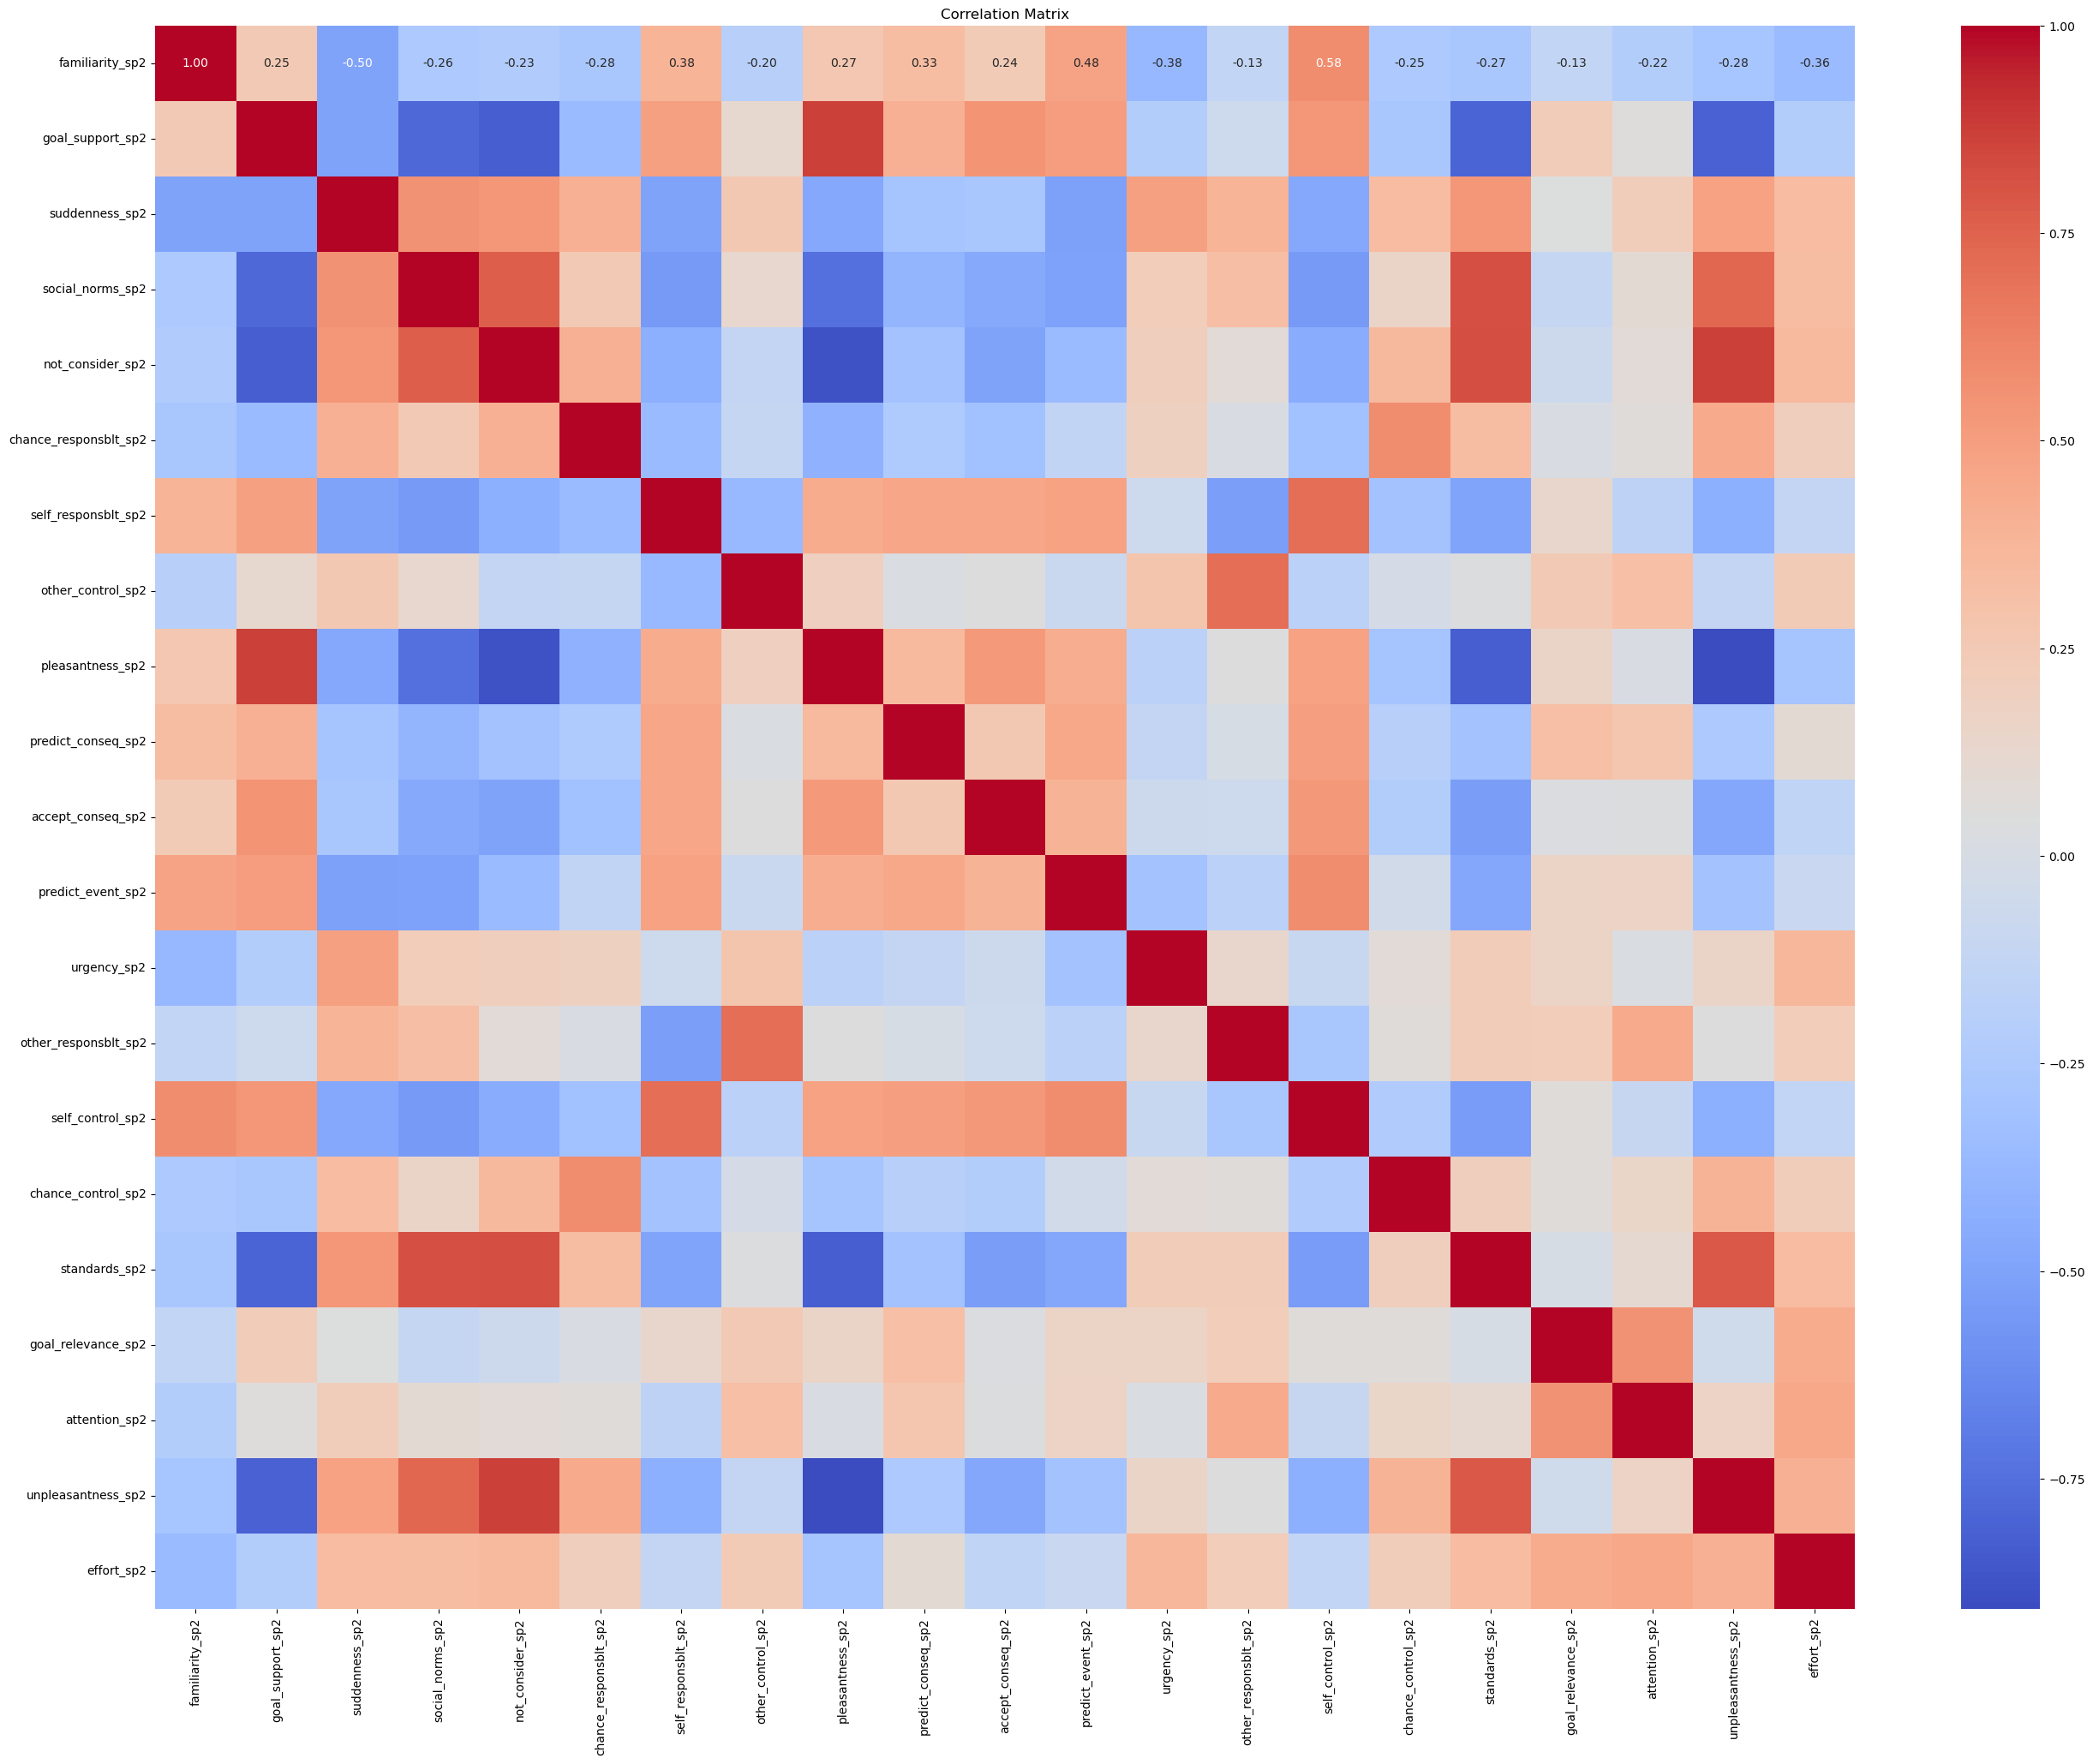

In [37]:
# emp-dial seeker text plot
plot_matrix(corr_matrix_empdial_sp2)

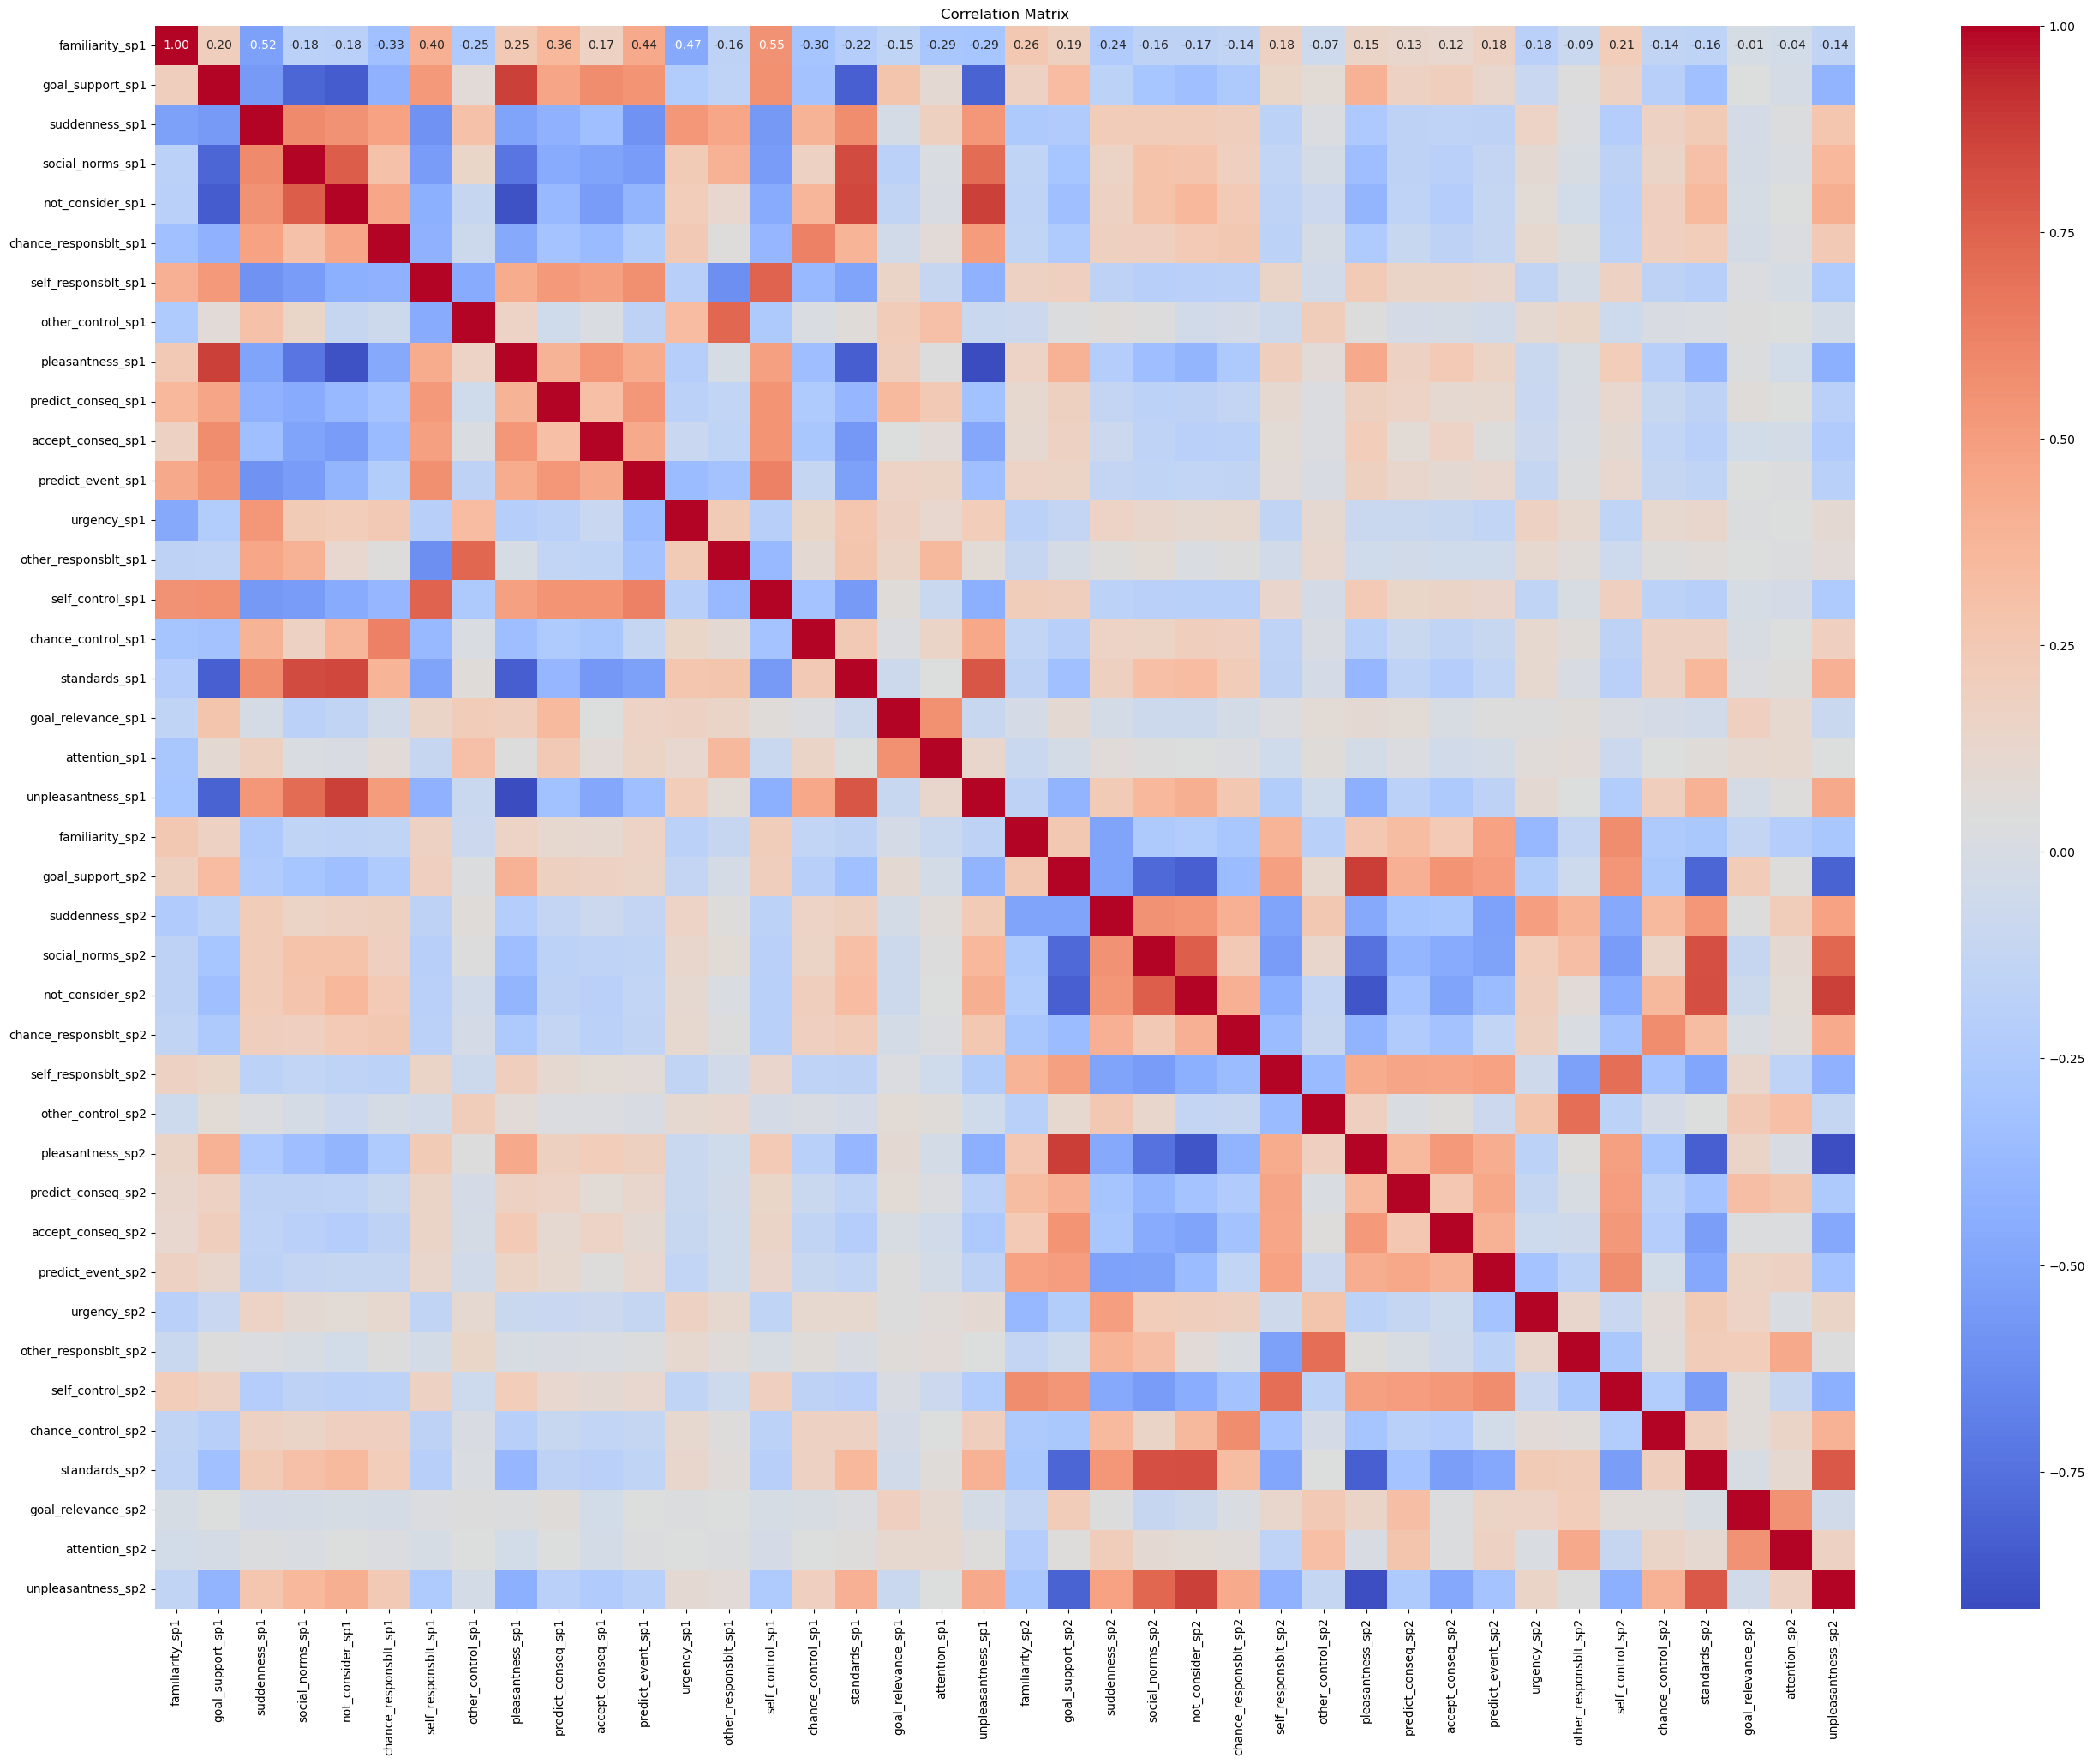

In [86]:
df = pd.read_csv('./appraised_dialogues/google-t5_empdial_train.csv')
cols = list(df.columns)
# cols
col_list = []
for col in cols:
    if '_sp1' in col or '_sp2' in col:
        col_list.append(col)

df = df[col_list]
corr_matrix = df.corr()
plot_matrix(corr_matrix)

In [55]:
df_wassa= pd.read_csv('./appraised_dialogues/google-t5_wassa_train.csv')
cols = list(df_wassa.columns)
col_list = []
for col in cols:
    if '_sp1' in col:
        col_list.append(col)

df_wassa_sp1 = df_wassa[col_list]
corr_matrix_wassa_sp1 = df_wassa_sp1.corr()
print(corr_matrix_wassa_sp1)

                       familiarity_sp1  goal_support_sp1  suddenness_sp1  \
familiarity_sp1               1.000000          0.248039       -0.358103   
goal_support_sp1              0.248039          1.000000       -0.373397   
suddenness_sp1               -0.358103         -0.373397        1.000000   
social_norms_sp1             -0.258693         -0.669697        0.398430   
not_consider_sp1             -0.159694         -0.701419        0.504075   
chance_responsblt_sp1        -0.250108         -0.214472        0.384865   
self_responsblt_sp1           0.436986          0.441466       -0.330999   
other_control_sp1            -0.173513          0.119771        0.143889   
pleasantness_sp1              0.244416          0.813407       -0.402975   
predict_conseq_sp1            0.342465          0.412351       -0.179474   
accept_conseq_sp1             0.219959          0.459747       -0.120323   
predict_event_sp1             0.367322          0.418885       -0.289016   
urgency_sp1 

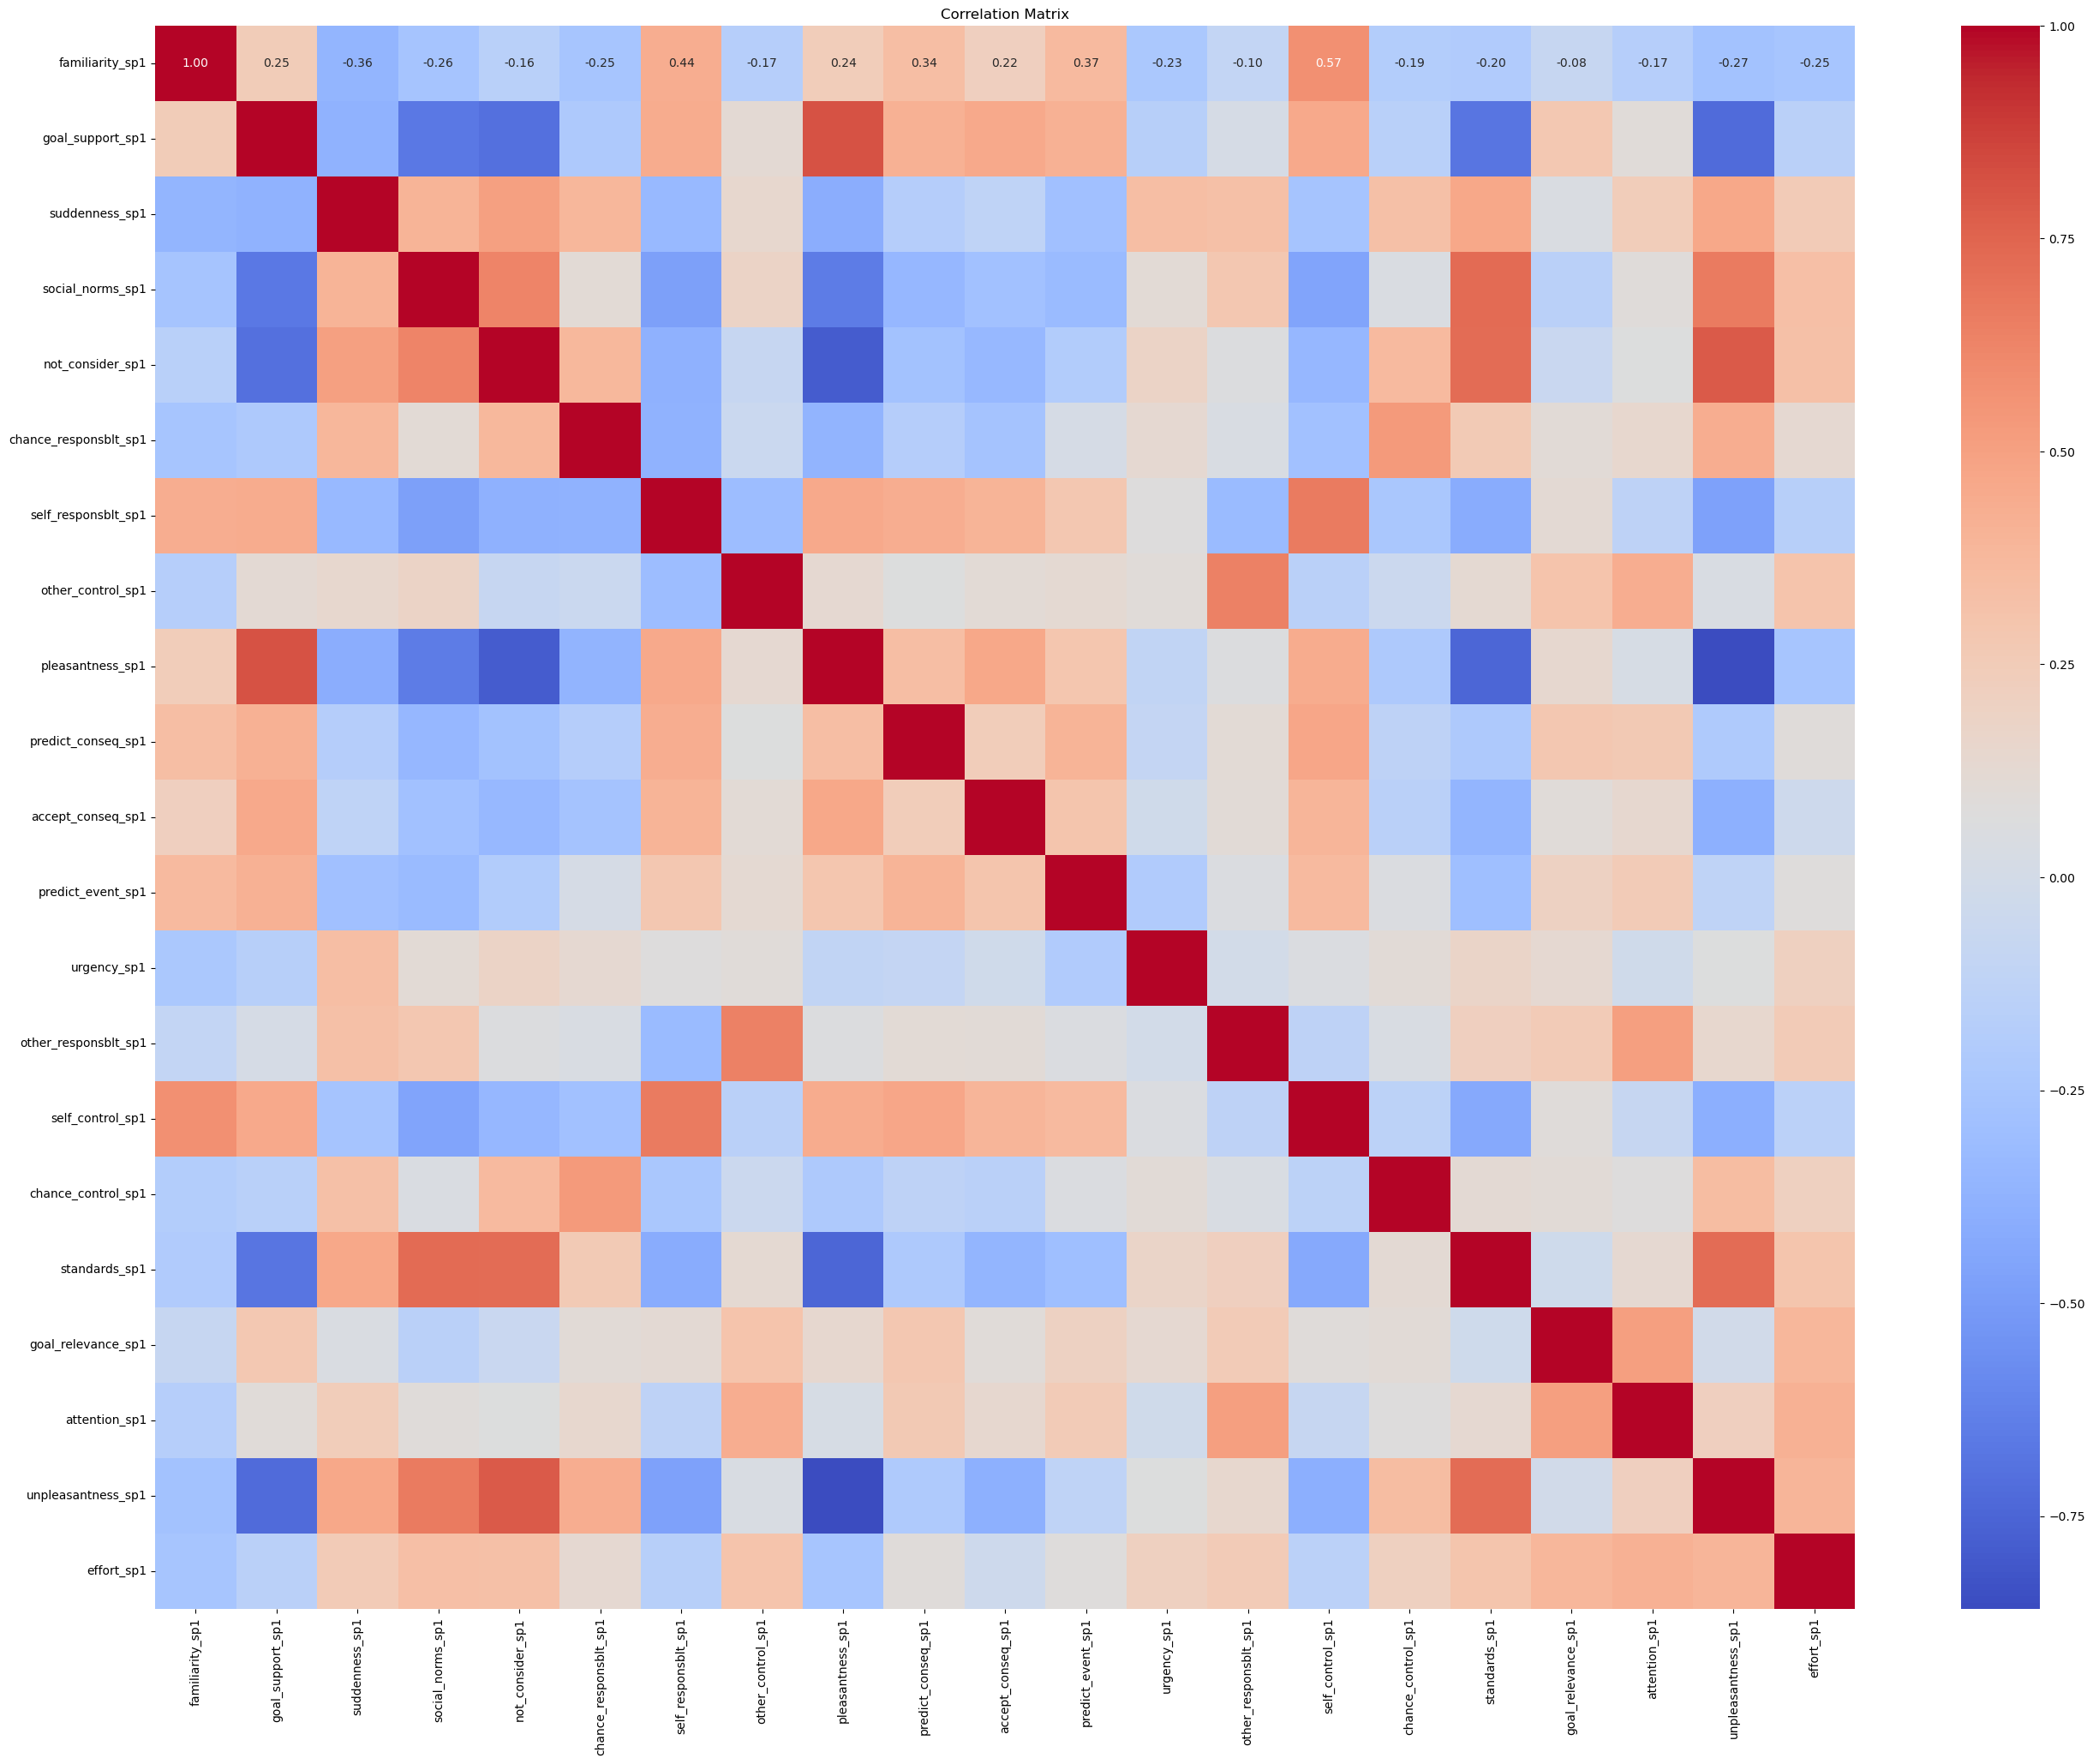

In [56]:
plot_matrix(corr_matrix_wassa_sp1)

In [57]:
col_list = []
for col in cols:
    if '_sp2' in col:
        col_list.append(col)

df_wassa_sp2 = df_wassa[col_list]
corr_matrix_wassa_sp2 = df_wassa_sp2.corr()
print(corr_matrix_wassa_sp2)

                       familiarity_sp2  goal_support_sp2  suddenness_sp2  \
familiarity_sp2               1.000000          0.270283       -0.331866   
goal_support_sp2              0.270283          1.000000       -0.372566   
suddenness_sp2               -0.331866         -0.372566        1.000000   
social_norms_sp2             -0.240629         -0.679783        0.416850   
not_consider_sp2             -0.130364         -0.682323        0.519545   
chance_responsblt_sp2        -0.240022         -0.222472        0.404232   
self_responsblt_sp2           0.400489          0.427157       -0.350186   
other_control_sp2            -0.158738          0.097128        0.147062   
pleasantness_sp2              0.234220          0.805188       -0.429047   
predict_conseq_sp2            0.280709          0.430764       -0.214722   
accept_conseq_sp2             0.243325          0.447885       -0.119332   
predict_event_sp2             0.345033          0.434065       -0.294444   
urgency_sp2 

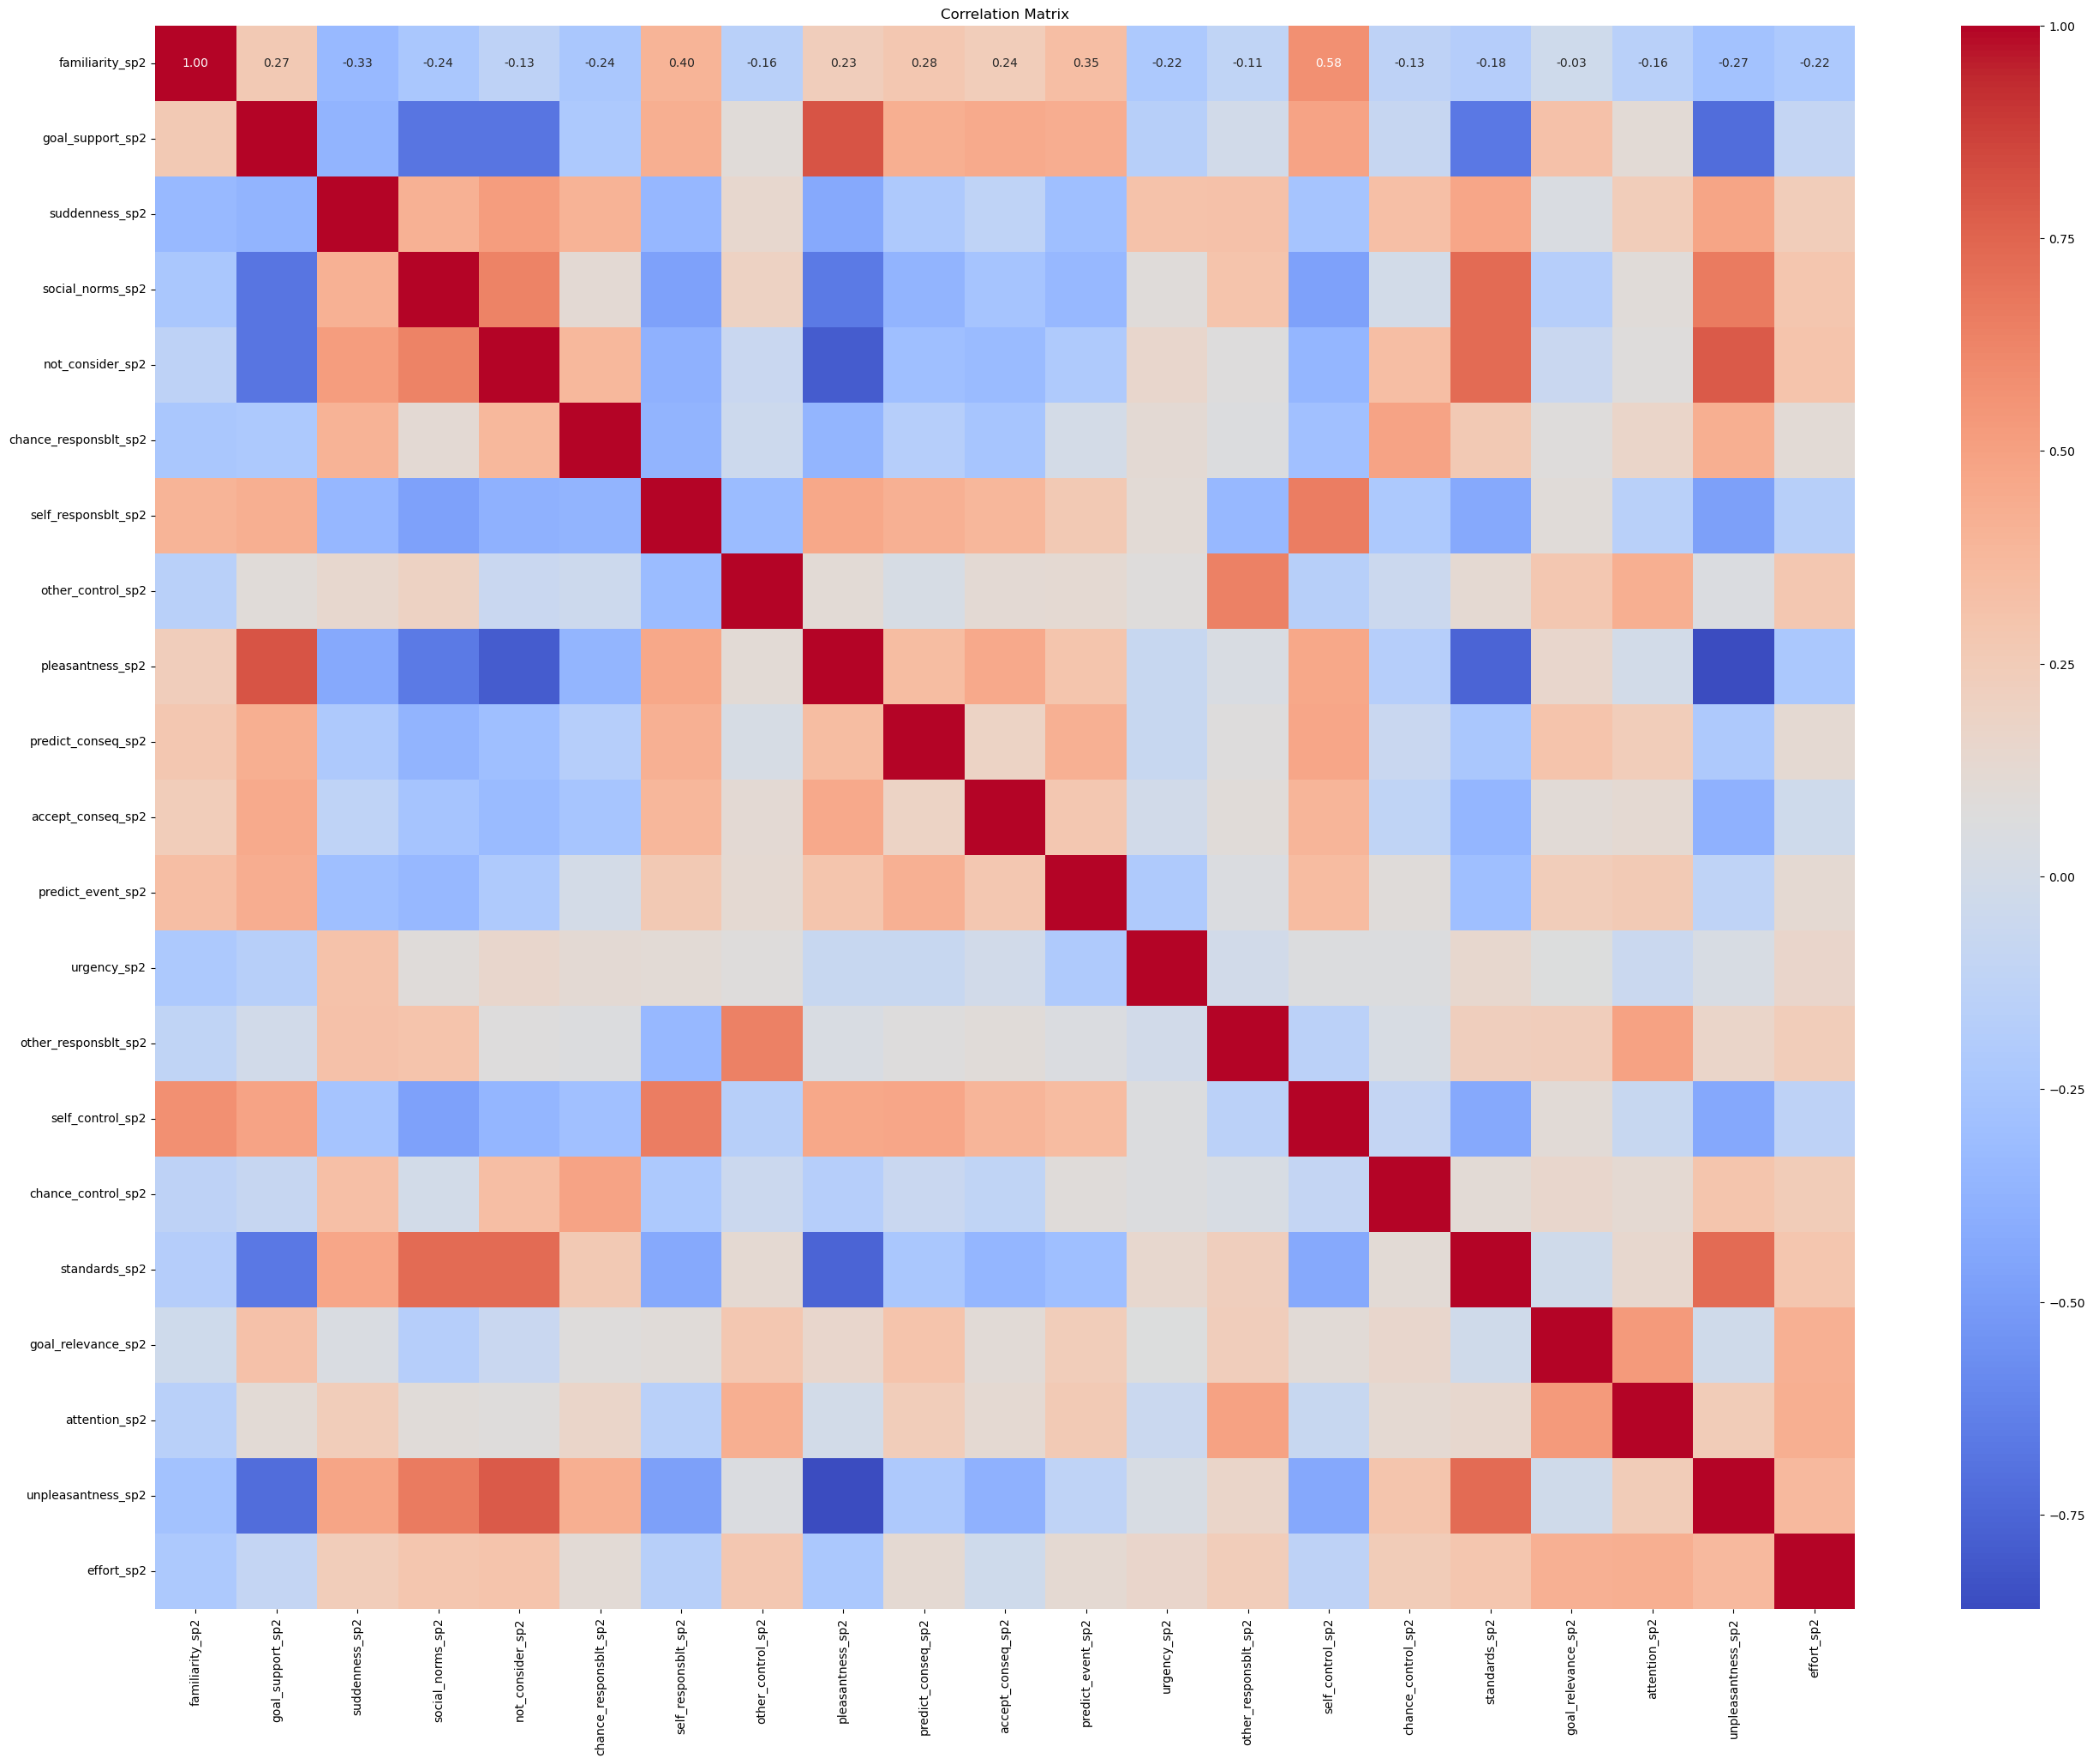

In [58]:
plot_matrix(corr_matrix_wassa_sp2)

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

print(stats.spearmanr(upper(corr_matrix_aloe_observer), upper(corr_matrix_aloe_target)))
print(stats.spearmanr(upper(corr_matrix_epitome_response), upper(corr_matrix_epitome_seeker)))
print(stats.spearmanr(upper(corr_matrix_empdial_sp1), upper(corr_matrix_empdial_sp2)))
print(stats.spearmanr(upper(corr_matrix_wassa_sp1), upper(corr_matrix_wassa_sp2)))
print(stats.spearmanr(upper(corr_matrix_condolence_observer), upper(corr_matrix_condolence_target)))

SignificanceResult(statistic=0.9247560436868787, pvalue=8.270233282912137e-81)
SignificanceResult(statistic=0.9381105468732915, pvalue=1.6491739856915364e-88)
SignificanceResult(statistic=0.9936962825912952, pvalue=1.2503740360000166e-180)
SignificanceResult(statistic=0.9960249664300368, pvalue=2.0875240423178296e-199)
SignificanceResult(statistic=0.9363102345742194, pvalue=2.2425099832441693e-87)


In [130]:
print(stats.spearmanr(upper(corr_matrix_epitome_response), upper(corr_matrix_empdial_sp1)))

SignificanceResult(statistic=0.8856198086840138, pvalue=1.5634187741454273e-64)


In [29]:
from scipy.stats import pearsonr
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi_square_value,p_value=calculate_bartlett_sphericity(df_condolence_observer)
kmo_all,kmo_model=calculate_kmo(df_condolence_observer)

/home/adebnath/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [30]:
chi_square_value, p_value, kmo_all, kmo_model

(10831.63277181219,
 0.0,
 array([0.84576642, 0.92474374, 0.66812275, 0.93106792, 0.89805828,
        0.84959211, 0.81335451, 0.58146282, 0.87194908, 0.90640849,
        0.84512532, 0.90610507, 0.85741282, 0.71898704, 0.87743772,
        0.81390128, 0.89469005, 0.72288783, 0.50210765, 0.69228988]),
 0.8391120188328414)

In [31]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_epitome_response)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
for i in ev:
        print(f"\t\t{i}")

		6.576059715440021
		3.010942215227394
		2.2340828639449524
		1.6299657521942734
		1.3857668088115478
		0.9358792937992757
		0.6252905938070208
		0.5177609970692768
		0.5040784744806949
		0.45611772106903
		0.343185393509341
		0.28851481888150876
		0.265407147742021
		0.24862685664154163
		0.2134817074783112
		0.20237532519705764
		0.1794559556131669
		0.15131291945943107
		0.14394709853854207
		0.08774834109558818


In [62]:
"""Nonparametric permutation testing Monte Carlo"""

def npmc(m1, m2):
    np.random.seed(0)
    rhos = []
    n_iter = 5000
    true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
      np.random.shuffle(m_ids) # shuffle list 
      r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
      rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test
    
    
    f,ax = plt.subplots()
    plt.hist(rhos,bins=20)
    ax.axvline(true_rho,  color = 'r', linestyle='--')
    ax.set(title=f"Permuted p: {perm_p:.5f}", ylabel="counts", xlabel="rho")
    plt.show()

In [39]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import numpy as np

def mantel_test(X, Y, perms=10000, method='pearson', alternative='greater'):
    X = squareform(X)
    Y = squareform(Y)
    
    nx = X.shape[0]
    ny = Y.shape[0]
    
    if nx != ny:
        raise ValueError("X and Y must have the same size.")
    
    robs = pearsonr(X.flatten(), Y.flatten())[0]
    
    perm_rs = np.zeros(perms)
    
    for i in range(perms):
        Yp = squareform(np.random.permutation(squareform(Y)))
        perm_rs[i] = pearsonr(X.flatten(), Yp.flatten())[0]
    
    if alternative == 'two-sided':
        p = np.sum(np.abs(perm_rs) >= np.abs(robs)) / perms
    elif alternative == 'greater':
        p = np.sum(perm_rs >= robs) / perms
    elif alternative == 'less':
        p = np.sum(perm_rs <= robs) / perms
    else:
        raise ValueError("Alternative must be 'two-sided', 'greater', or 'less'.")
    
    return robs, p

In [41]:
def ratio(m1, m2):
    m = m1.to_numpy() / m2.to_numpy()
    columns = ['_'.join(col.split('_')[:-1]) + '_d' for col in m1.columns]
    d_map = pd.DataFrame(m, columns=columns, index=columns)
    plt.figure(figsize=(32, 24))
    sns.heatmap(d_map, annot=True, cmap='viridis', fmt='.2f', vmin=-30, vmax=30)
    plt.title('Ratios of Correlation Matrix')
    plt.show()

Mantel statistic r: 0.9586846754173967
p-value: 0.0


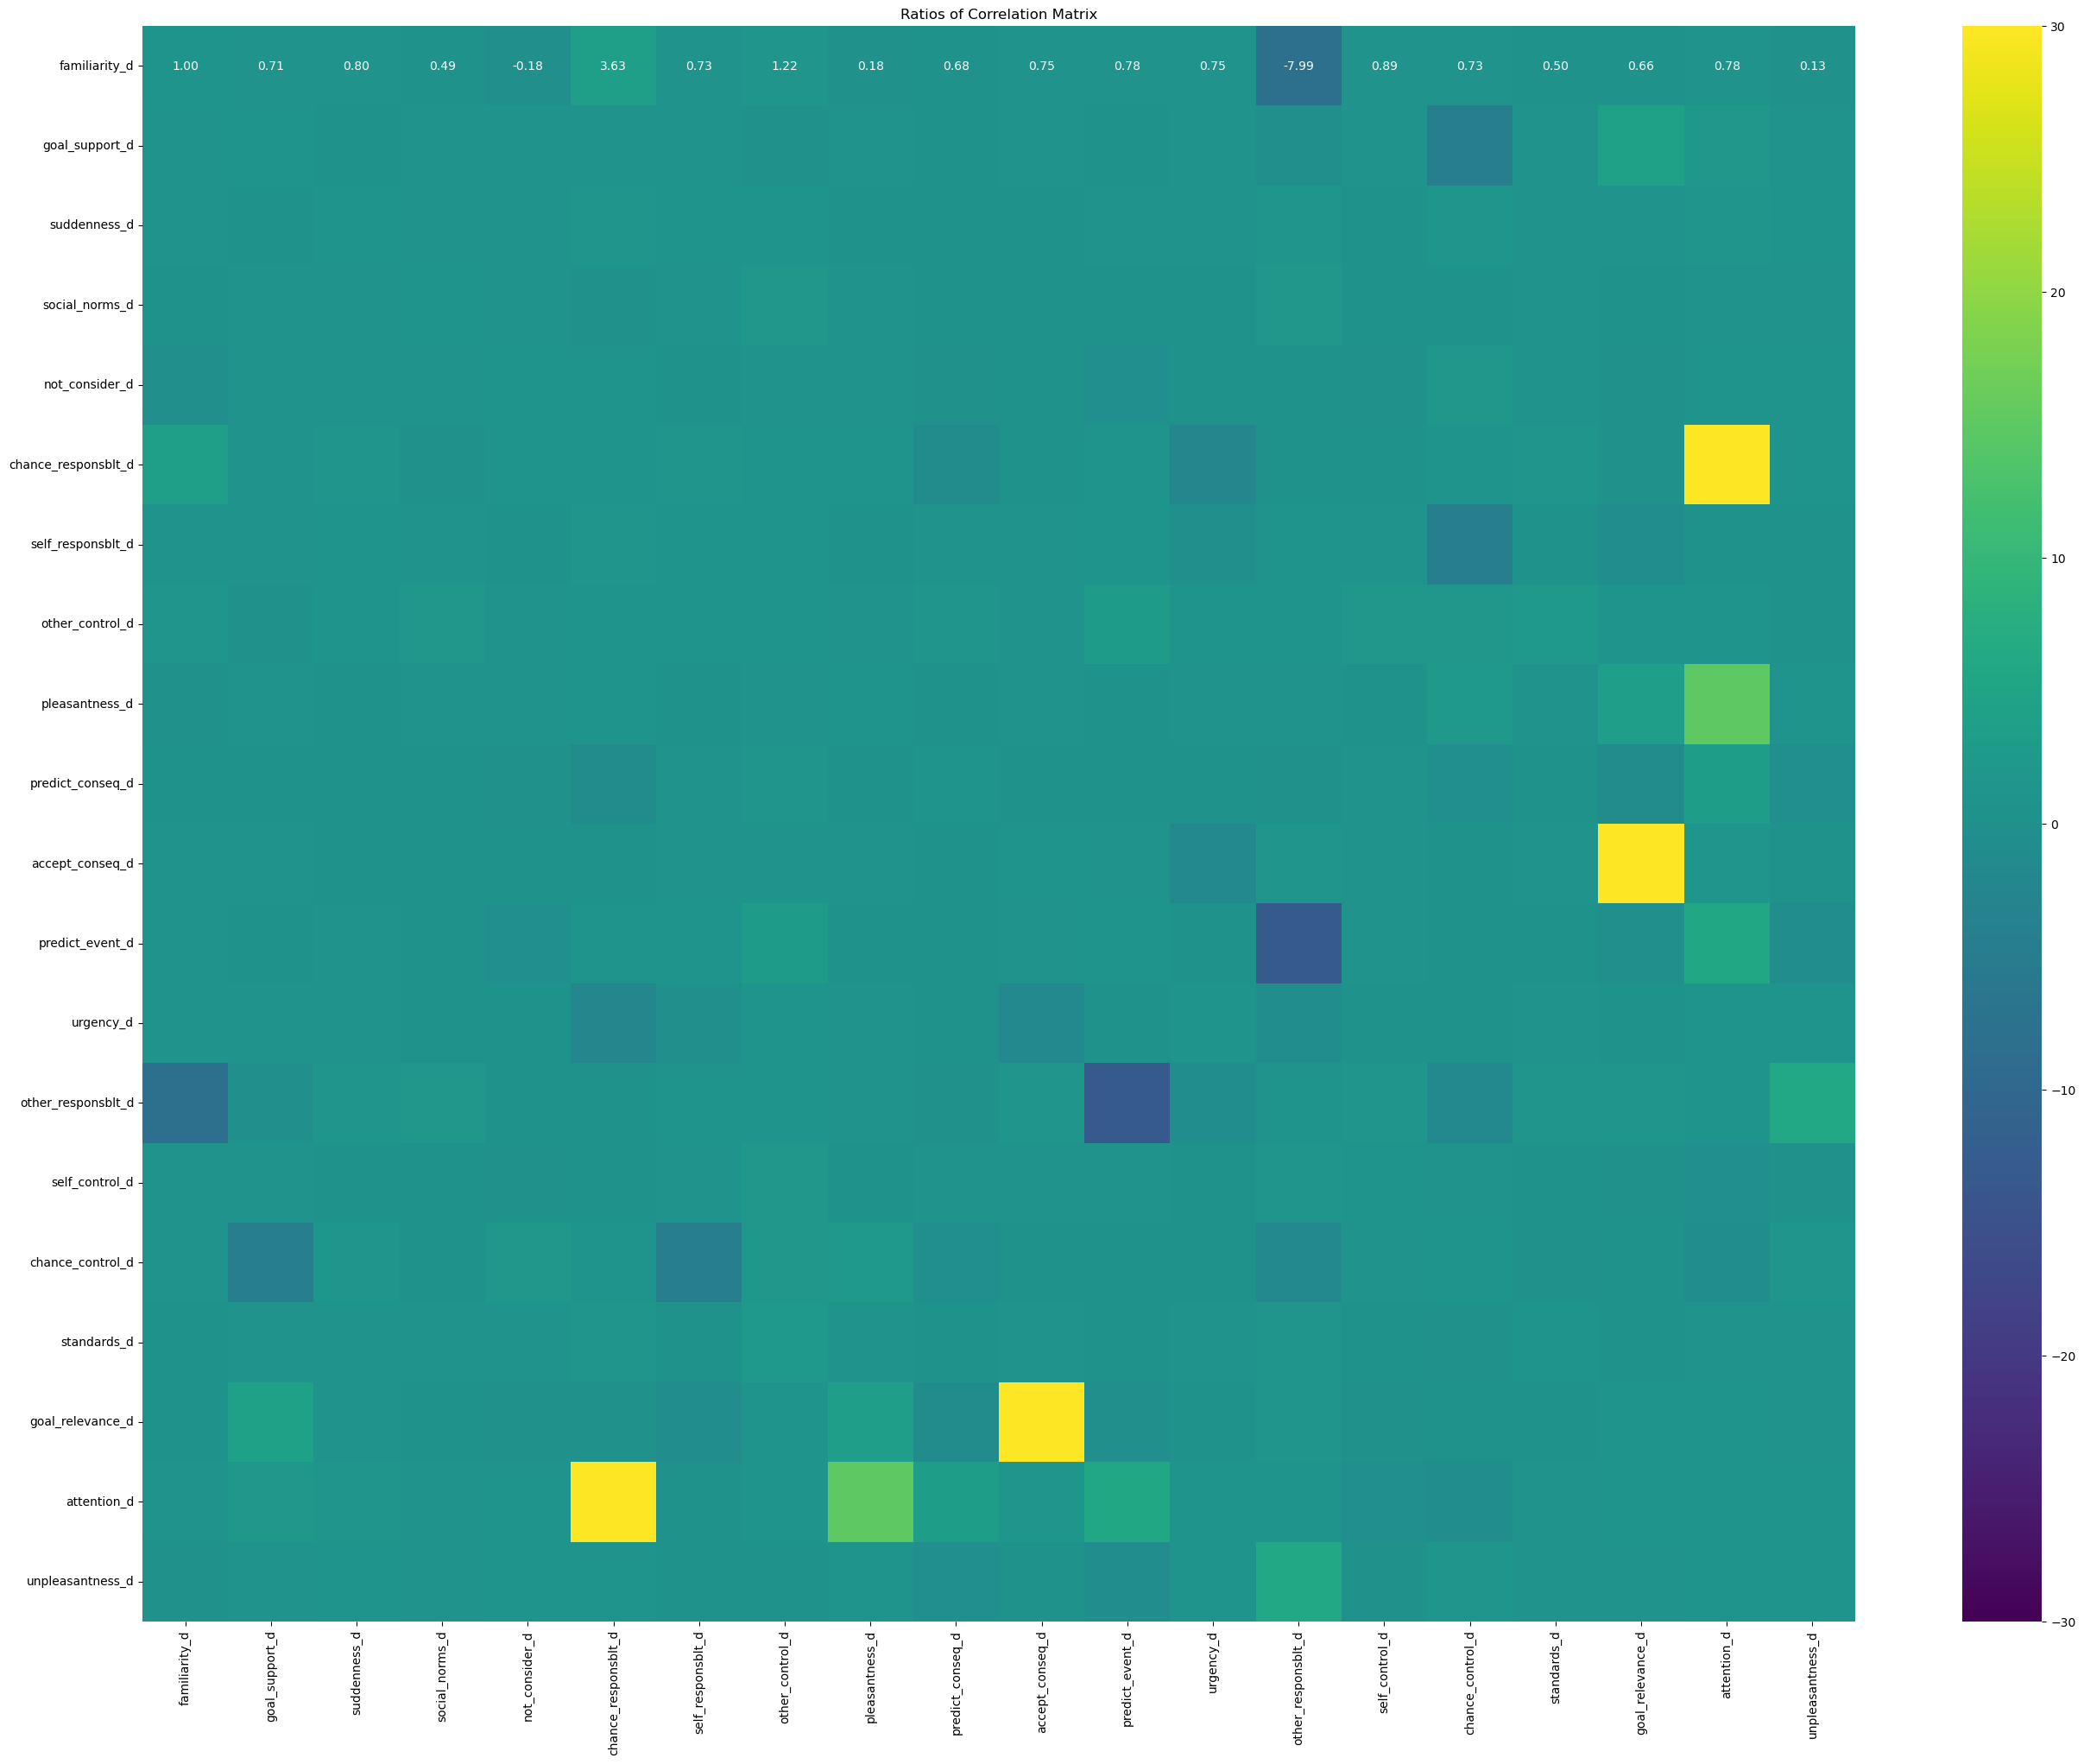

In [93]:
m1 = corr_matrix_epitome_seeker
m2 = corr_matrix_epitome_response

X_dist = pdist(m1)
Y_dist = pdist(m2)
r, p = mantel_test(X_dist, Y_dist, perms=9999)
print(f"Mantel statistic r: {r}")
print(f"p-value: {p}")
ratio(m1, m2)

Mantel statistic r: 0.9573375140441953
p-value: 0.0


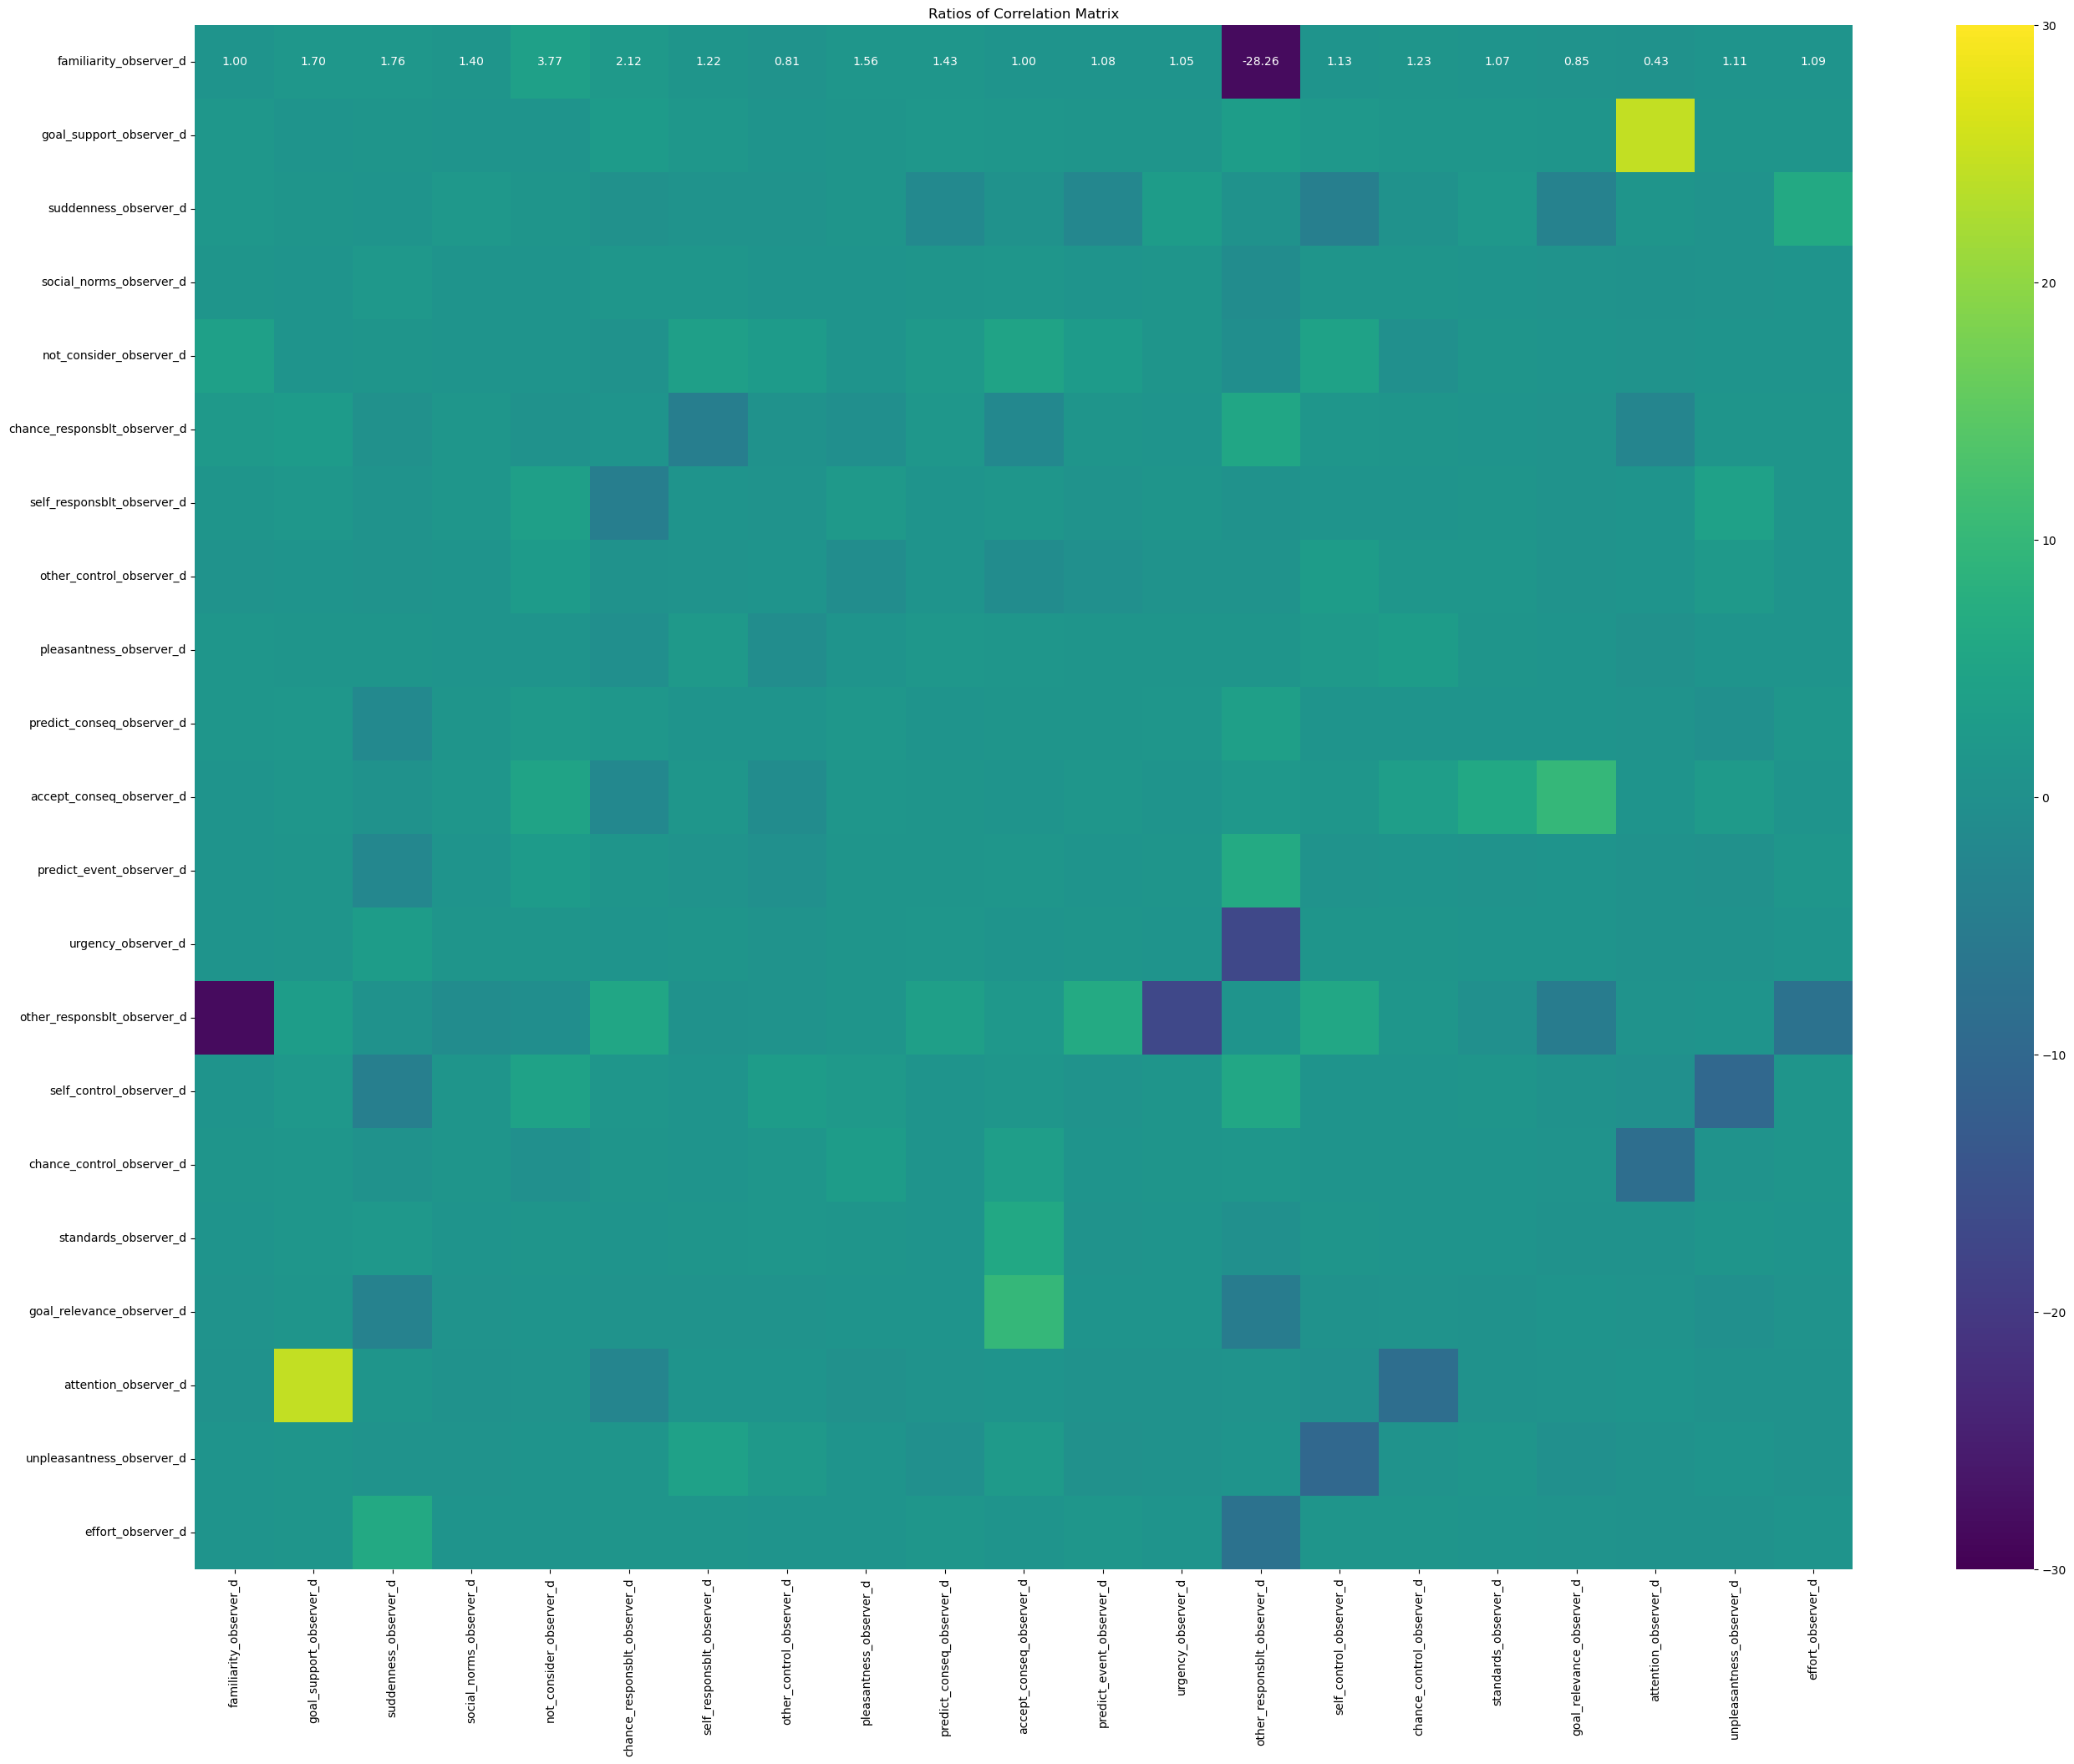

In [68]:
m1 = corr_matrix_aloe_observer
m2 = corr_matrix_aloe_target

X_dist = pdist(m1)
Y_dist = pdist(m2)
r, p = mantel_test(X_dist, Y_dist, perms=9999)
print(f"Mantel statistic r: {r}")
print(f"p-value: {p}")
ratio(m1, m2)

Mantel statistic r: 0.9945381498303085
p-value: 0.0


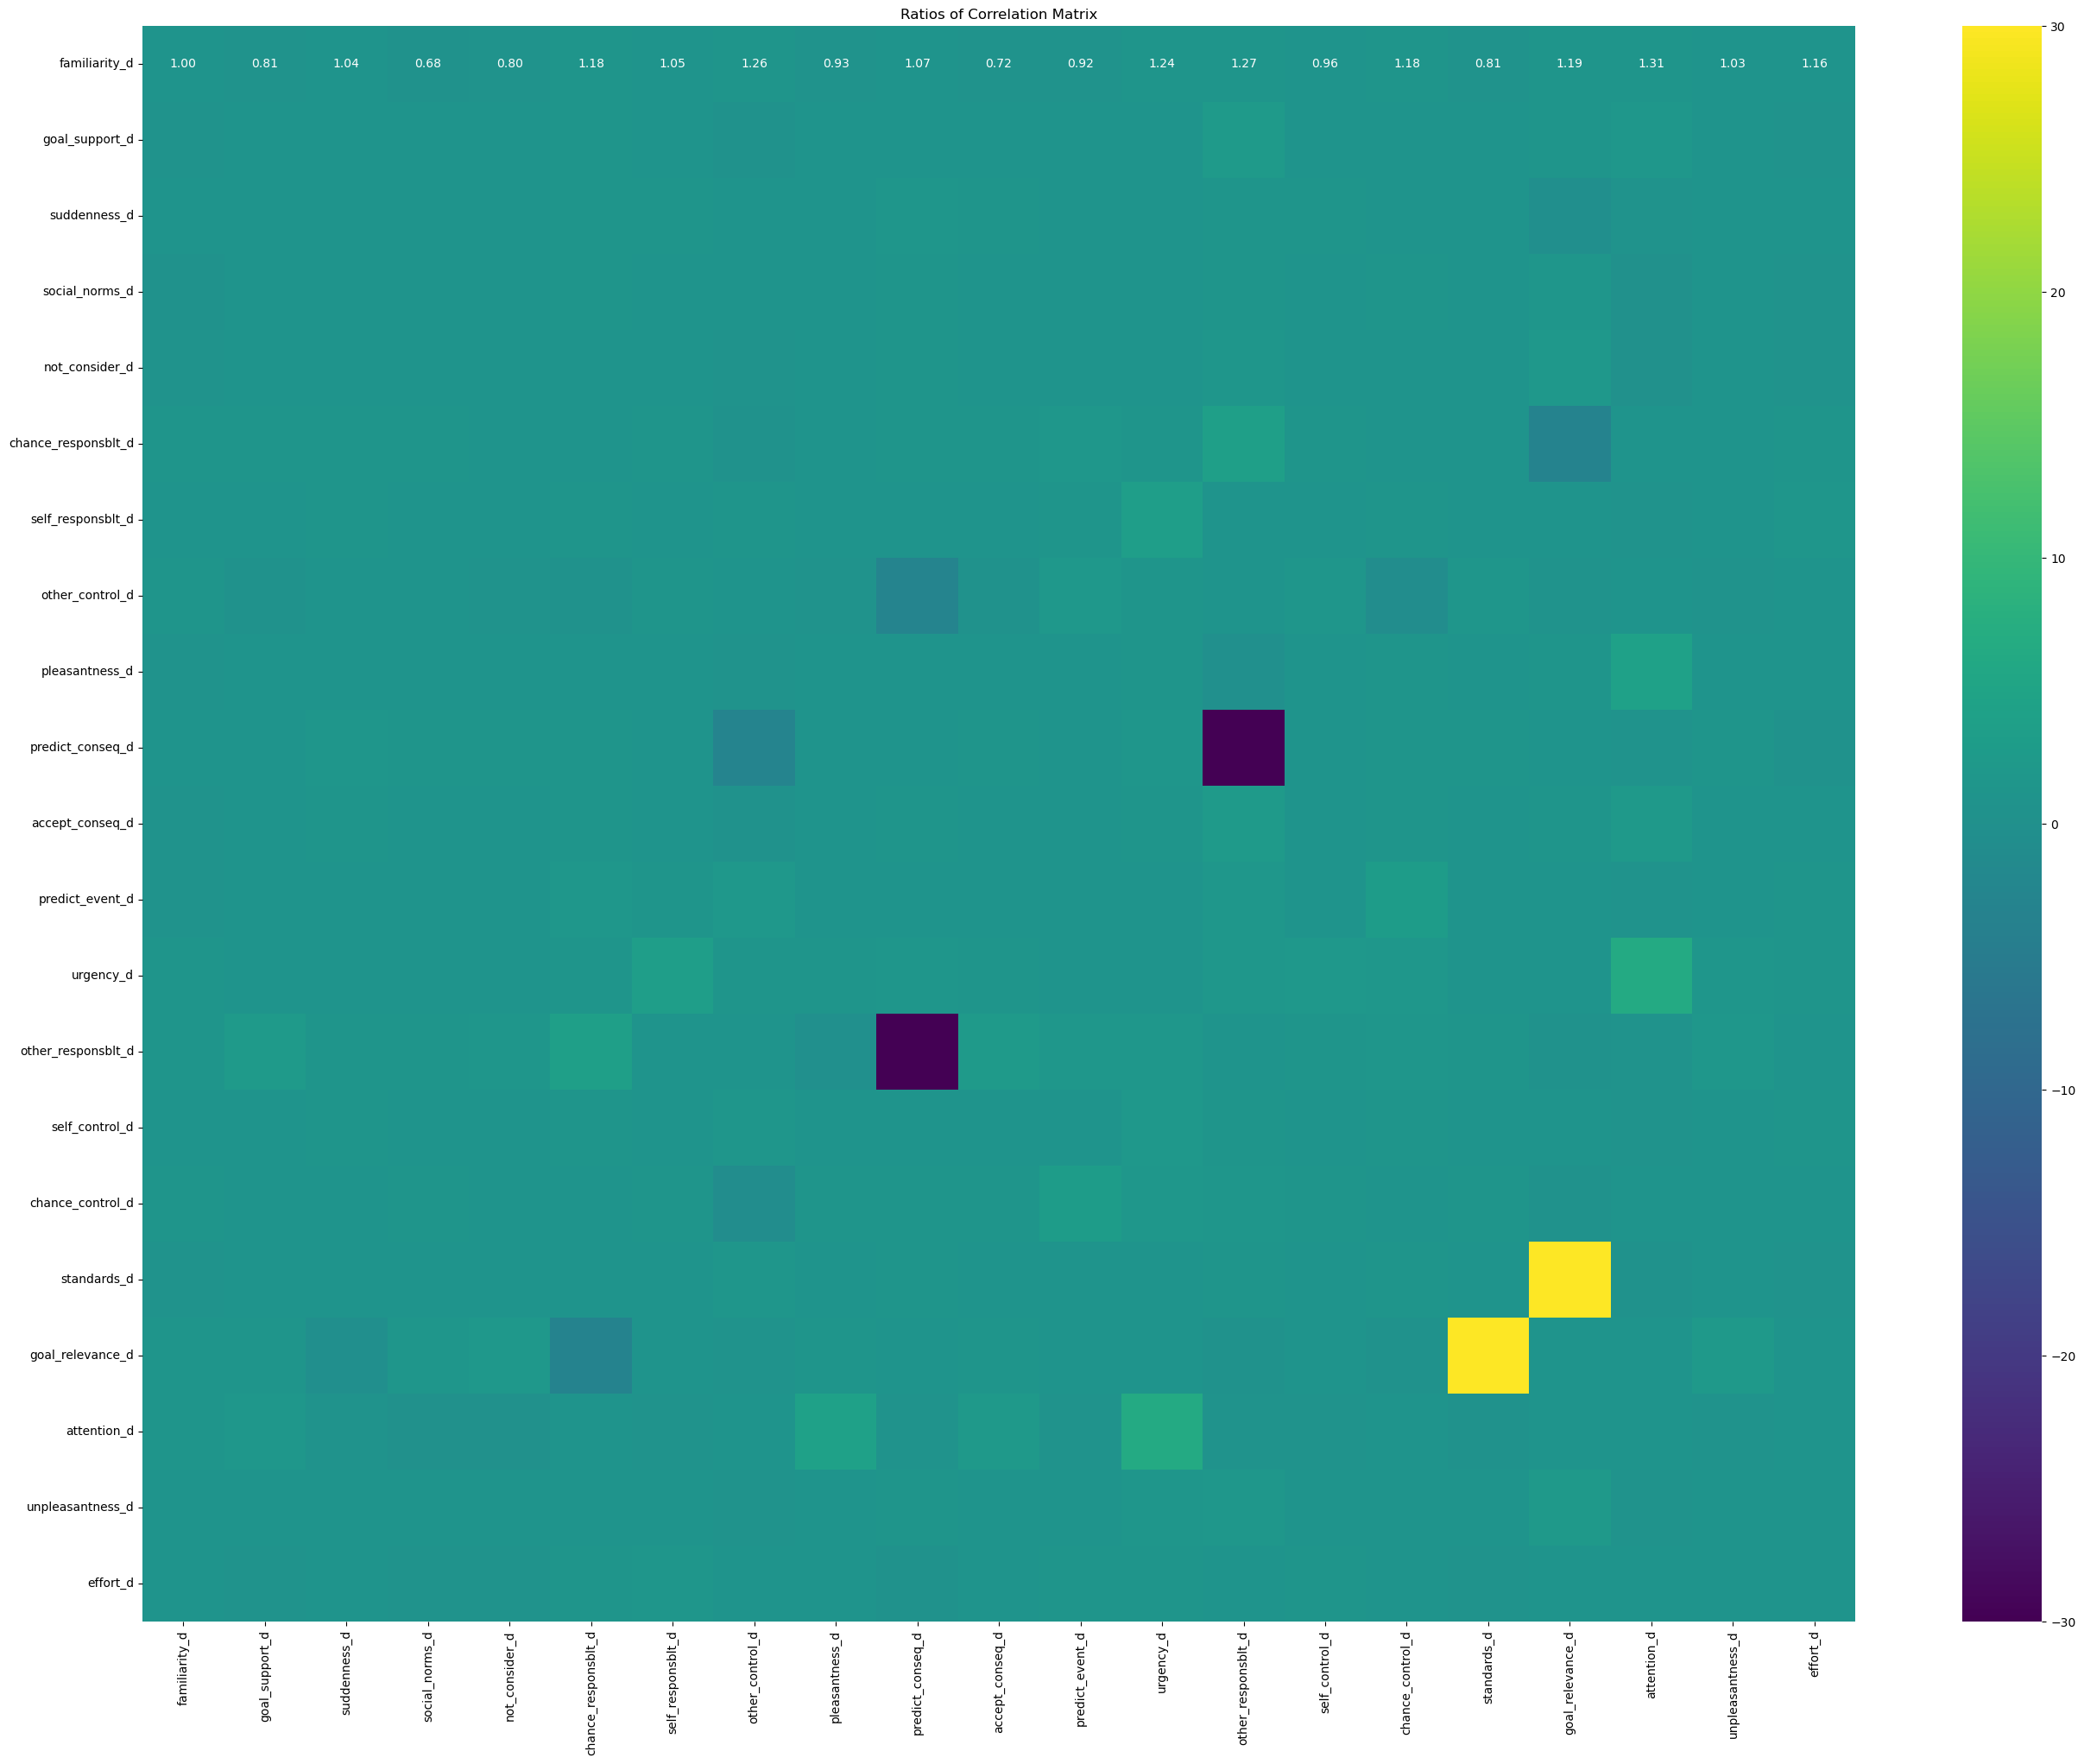

In [42]:
m1 = corr_matrix_empdial_sp1
m2 = corr_matrix_empdial_sp2

X_dist = pdist(m1)
Y_dist = pdist(m2)
r, p = mantel_test(X_dist, Y_dist, perms=9999)
print(f"Mantel statistic r: {r}")
print(f"p-value: {p}")
ratio(m1, m2)

Mantel statistic r: 0.9575104091473147
p-value: 0.0


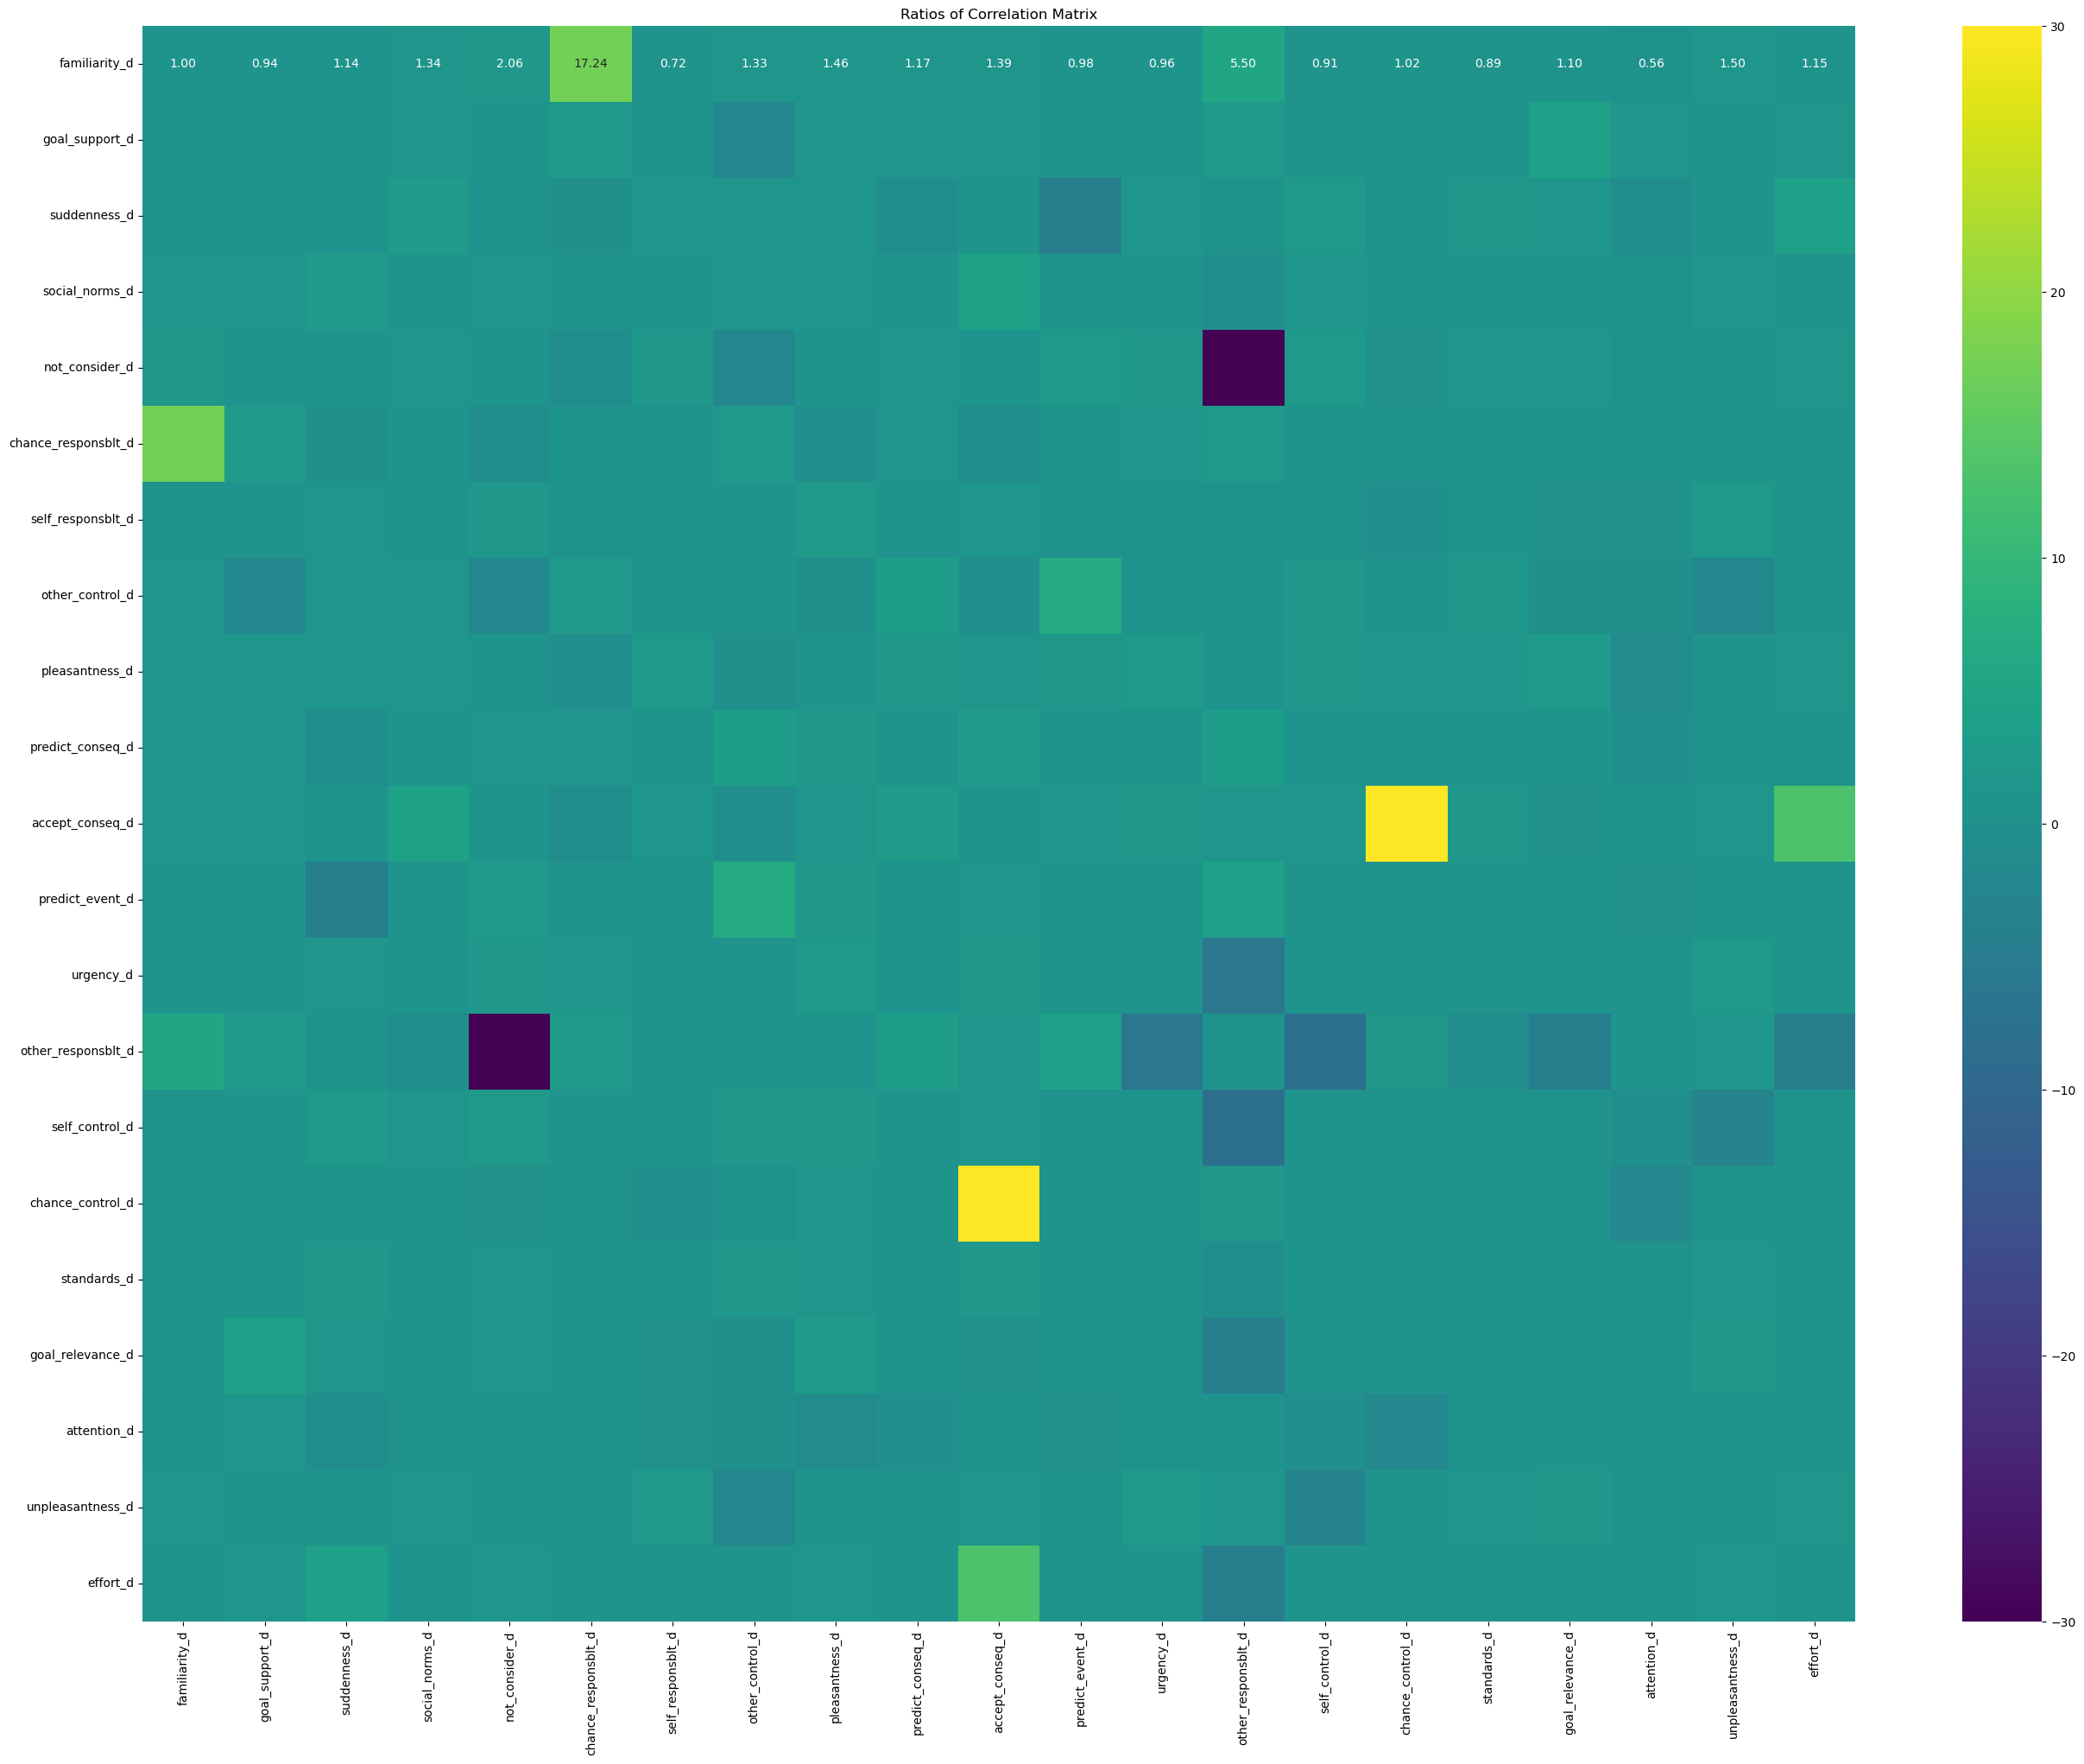

In [69]:
m1 = corr_matrix_condolence_observer
m2 = corr_matrix_condolence_target

X_dist = pdist(m1)
Y_dist = pdist(m2)
r, p = mantel_test(X_dist, Y_dist, perms=9999)
print(f"Mantel statistic r: {r}")
print(f"p-value: {p}")
ratio(m1, m2)

Mantel statistic r: 0.9983364744797838
p-value: 0.0


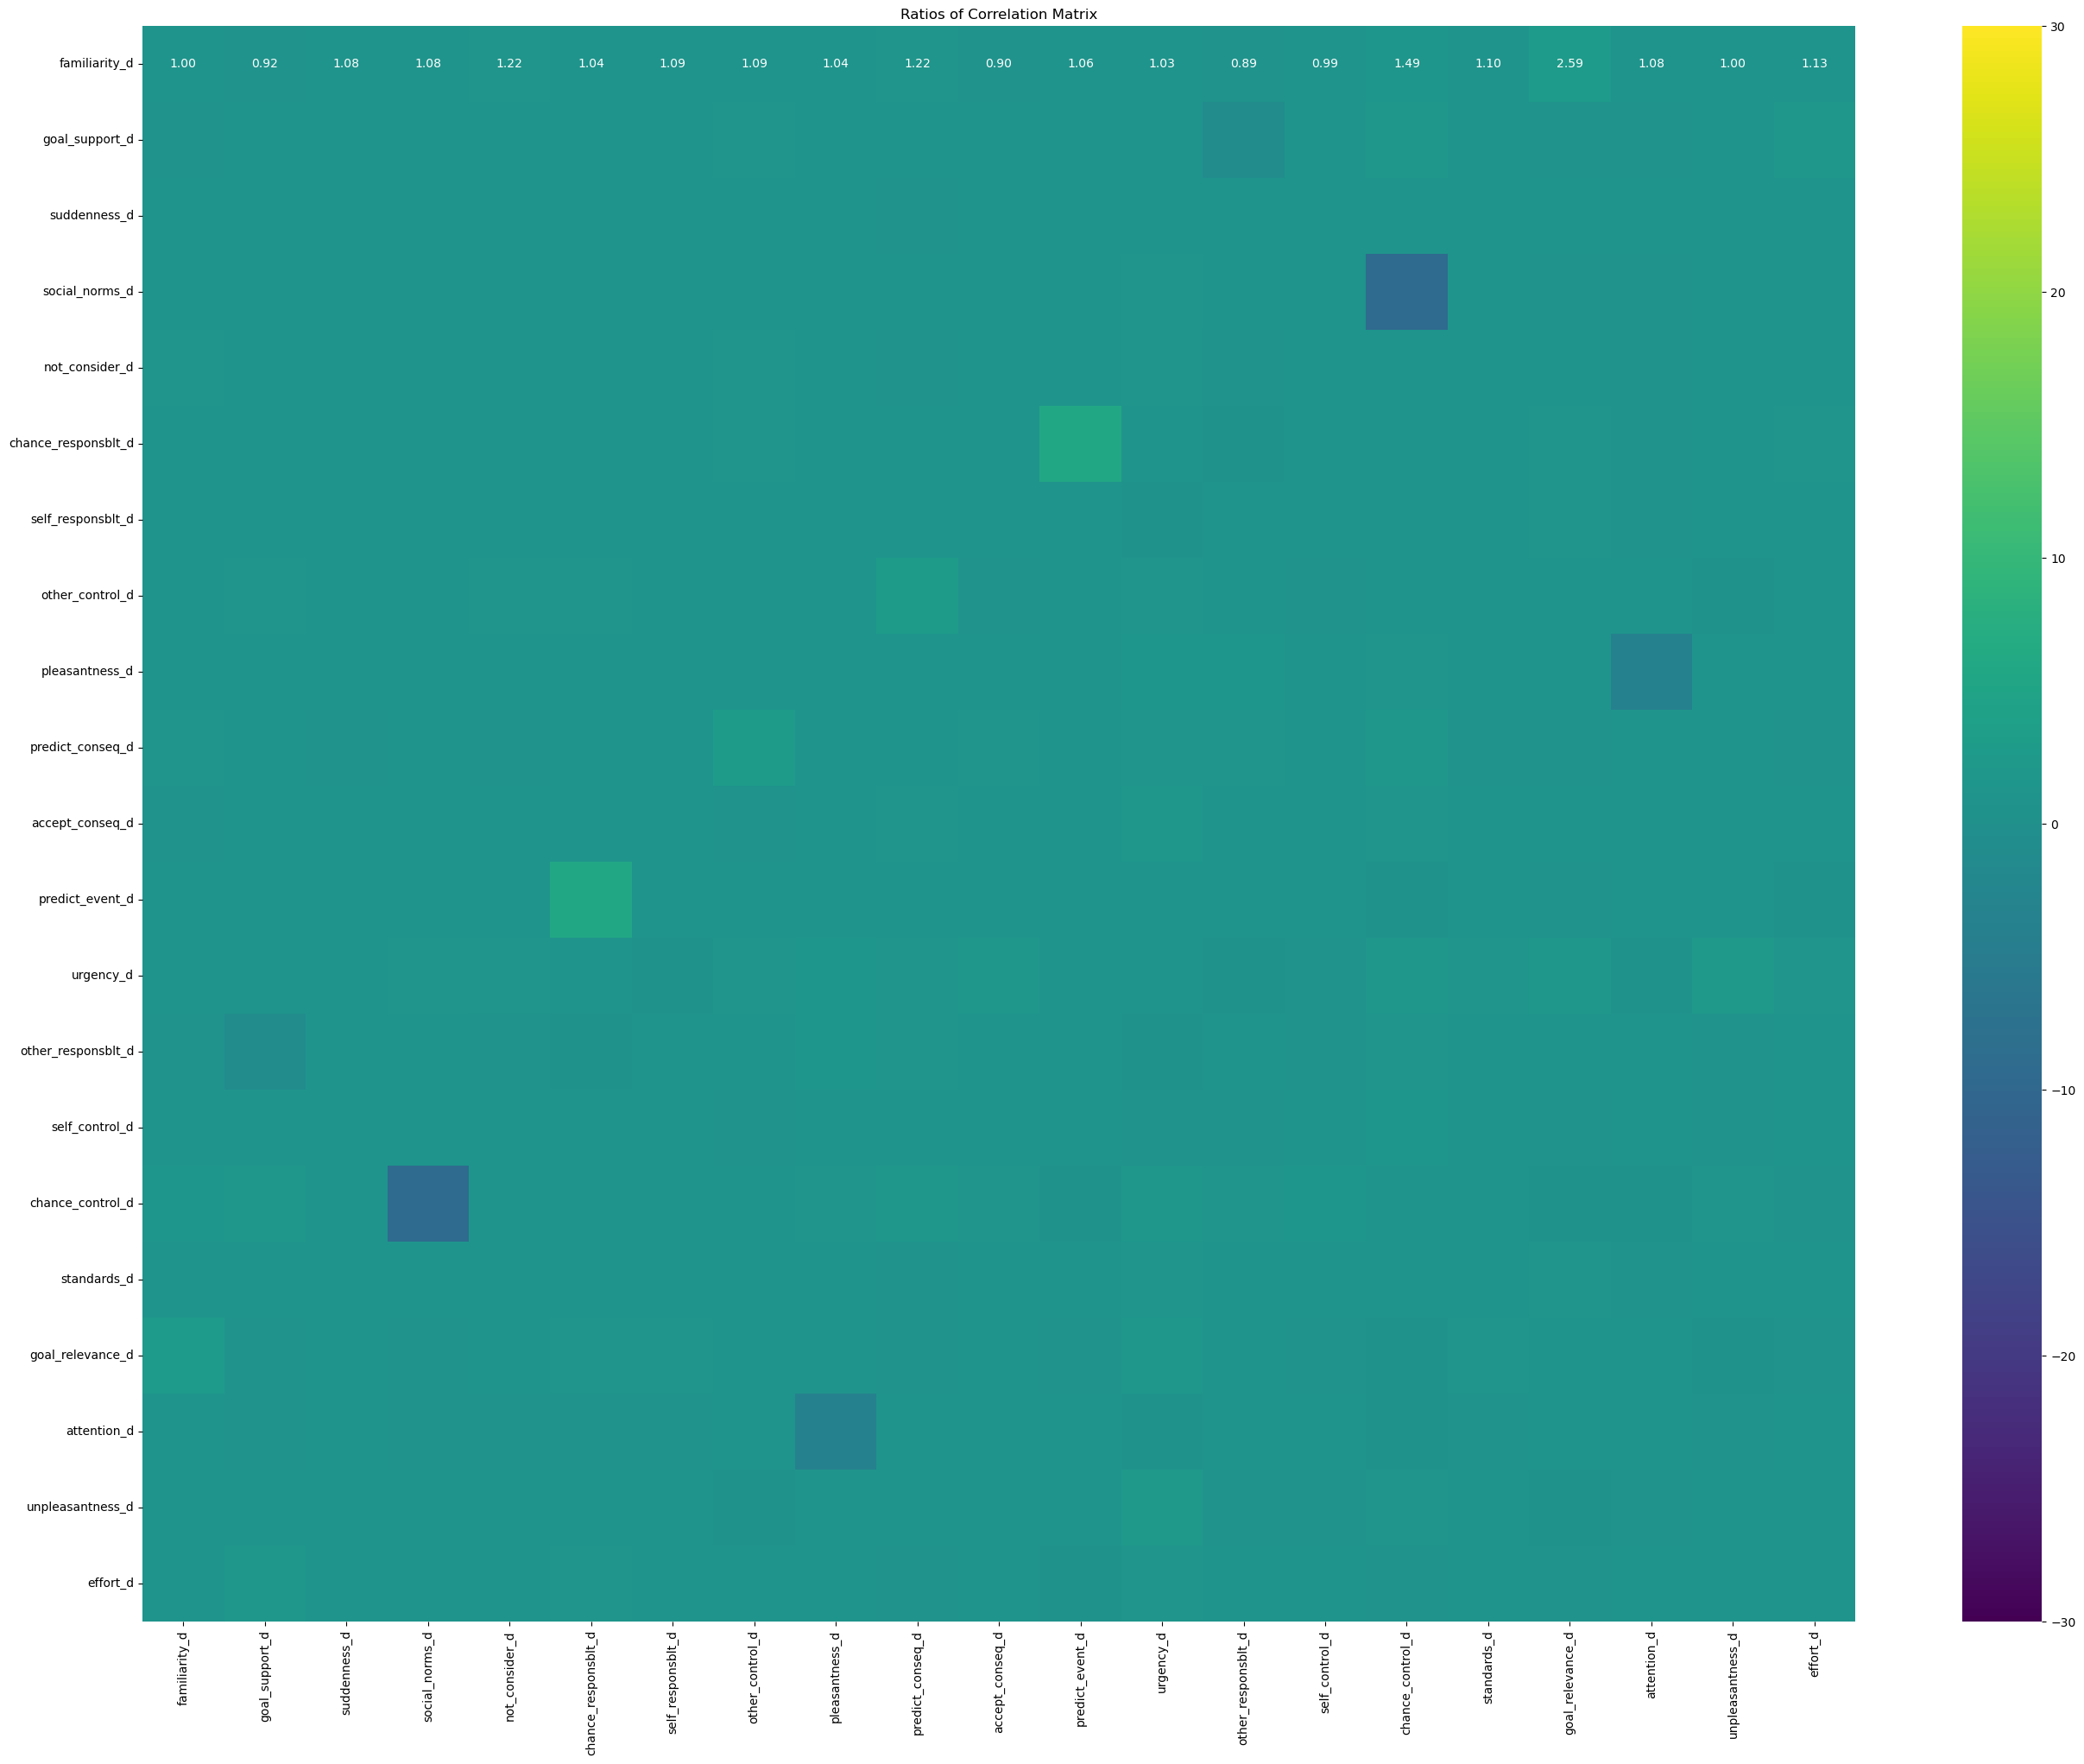

In [70]:
m1 = corr_matrix_wassa_sp1
m2 = corr_matrix_wassa_sp2

X_dist = pdist(m1)
Y_dist = pdist(m2)
r, p = mantel_test(X_dist, Y_dist, perms=9999)
print(f"Mantel statistic r: {r}")
print(f"p-value: {p}")
ratio(m1, m2)

In [51]:
emp_ef_df = pd.read_csv('./appraised_dialogues/google-t5_empdial_train_effort.csv')[['effort_sp1', 'effort_sp2']]
emp_df = pd.read_csv('./appraised_dialogues/google-t5_empdial_train.csv')
emp_df['effort_sp1'] = emp_ef_df['effort_sp1']
emp_df['effort_sp2'] = emp_ef_df['effort_sp2']
emp_df.to_csv('./appraised_dialogues/google-t5_empdial_train.csv')

In [45]:
wassa_ef_df = pd.read_csv('./appraised_dialogues/google-t5_wassa_train_effort.csv')
wassa_df = pd.read_csv('./appraised_dialogues/google-t5_wassa_train.csv')
wassa_df['effort_sp1'] = wassa_ef_df['effort_sp1']
wassa_df['effort_sp2'] = wassa_ef_df['effort_sp2']
wassa_df.to_csv('./appraised_dialogues/google-t5_wassa_train.csv')

In [52]:
aloe_ef_df = pd.read_csv('./appraised_dialogues/google-t5_ALOE_train_effort.csv')
aloe_df = pd.read_csv('./appraised_dialogues/google-t5_ALOE_train.csv')
aloe_df['effort_observer_text'] = aloe_ef_df['effort_observer_text']
aloe_df['effort_target_text'] = aloe_ef_df['effort_target_text']
aloe_df.to_csv('./appraised_dialogues/google-t5_ALOE_train.csv')

In [54]:
cond_ef_df = pd.read_csv('./appraised_dialogues/google-t5_condolence_train_effort.csv')
cond_df = pd.read_csv('./appraised_dialogues/google-t5_condolence_train.csv')
cond_df['effort_observer'] = cond_ef_df['effort_observer']
cond_df['effort_target'] = cond_ef_df['effort_target']
cond_df.to_csv('./appraised_dialogues/google-t5_condolence_train.csv')